# Data Preprocess

The dataset used in this experiment is National Travel Survey (NTS) data from 2005 to 2016, which can be assessed at the [UK Data Service](https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=5340). It provides three kinds of file formats: SPSS,STATA, and TAB. Here we use STATA format.

The population density data are publicly provided by [London Data Store](https://data.london.gov.uk/dataset/land-area-and-population-density-ward-and-borough).

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import os
import scipy
from scipy.signal import savgol_filter
import pickle as pkl
from util import config

import analysis
import data_preprocess
import nn
import plot


In [3]:
# Read the origin dataset 
data_trip = pd.read_stata('data/trip_eul_2002-2019.dta',convert_categoricals=False)
data_indi = pd.read_stata('data/individual_eul_2002-2019.dta',convert_categoricals=False)
data_hous = pd.read_stata('data/household_eul_2002-2019.dta',convert_categoricals=False)
data_psu=pd.read_stata('data/psu_eul_2002-2019.dta',convert_categoricals=False)

# preprocess the data and save them in the local
data_preprocess.data_clean(data_trip,data_hous,data_indi,data_psu,standard=True,statistics=True)
data_preprocess.data_clean(data_trip,data_hous,data_indi,data_psu,standard=False,statistics=False)

Summary statistics of variables have been saved in summary statistics folder.
Done. The sample size is: 2100492
Done. The sample size is: 2100492


In [2]:
# Read the preprocessed dataset 
with open('./data/data_stand.pkl','rb') as f:  
    data=pkl.load(f)
with open('./data/data_non_stand.pkl','rb') as f:  
    data_non_stand=pkl.load(f)

# Data Exploration

## Numbers of individuals and households

How many individuals and households are interviewed in these surveys?

In [3]:
print(f'Individuals: {len(set(data.IndividualID))}')
print(f'Households: {len(set(data.HouseholdID))}')

Individuals: 121765
Households: 69208


## Trip frequency by mode choice in 2016

In [9]:
data_non_stand=data_non_stand[data_non_stand.Year==2016].sort_values(by=['Mode','Household_region']).reset_index(drop=True)

In [10]:
years_str=config['experiments']['years']
region_name =config['experiments']['region']
travel_mode = config['experiments']['mode']
fixed_effect = config['experiments']['variables']

In [11]:
freq_mode=pd.DataFrame(columns=['Mode','Frequency','Percentage'],index=range(1,6))
freq_mode['Mode']=travel_mode
freq_mode['Frequency']=data_non_stand.Mode.value_counts()
freq_mode['Percentage']=freq_mode['Frequency']/data_non_stand.Mode.count()
freq_mode.to_csv('./table/exploration_freq_mode.csv')
freq_mode

Mode  Frequency  Percentage
1     Walk      16649    0.099268
2  Bicycle       3165    0.018871
3  Driving     131621    0.784780
4      Bus       8867    0.052869
5     Rail       7415    0.044211

## Travel mode share by different social group

### Region 

In [10]:
freq_mode_region=pd.DataFrame(columns=region_name,index=range(1,6))
for i in range(len(region_name)):
    freq_mode_region[region_name[i]]=data_non_stand[data_non_stand.Household_region==i+1].Mode.value_counts()
freq_mode_region.index=travel_mode
freq_mode_region=freq_mode_region.reindex(['Driving','Walk','Bus','Rail','Bicycle'],axis = 'rows')
freq_mode_region

North East  North West  Yorkshire and the Humber  East Midlands  \
Driving        6099       18421                     13154          12754   
Walk            806        2321                      1614           1541   
Bus             630        1216                       762            629   
Rail             10         476                       241            151   
Bicycle          96         350                       252            258   

         West Midlands  East of England  London  South East  South West  
Driving          14513            16989   10512       24895       14284  
Walk              1319             1894    2333        2785        2036  
Bus                786              587    2812         780         665  
Rail               237              968    3983        1136         213  
Bicycle            203              555     528         512         411

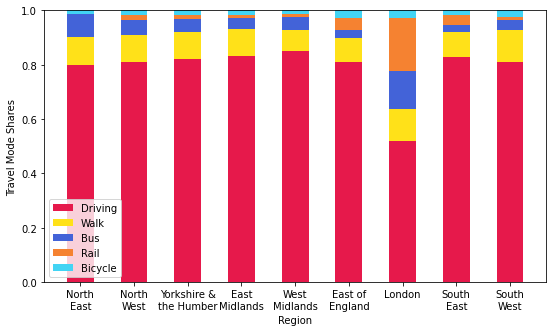

In [12]:
results=dict.fromkeys(region_name)
for i in range(len(region_name)):
    results[region_name[i]]= freq_mode_region[region_name[i]] / freq_mode_region[region_name[i]].sum()
    
plot.Mode_Share_Group(results, freq_mode_region,figsize=(9,5),region=True)
plt.xlabel('Region')
plt.legend(loc='lower left')

plt.savefig('image\\share_region.png',bbox_inches='tight',dpi=300)

### Age group

In [13]:
age=['0-16','17-20','21-29','30-39','40-49','50-59','60+']
age_num=[14,19,25,35,45,55,62]
freq_mode_age=pd.DataFrame(columns=age,index=range(1,6))
for i in range(len(age)):
    freq_mode_age[age[i]]=data_non_stand[data_non_stand.Individual_age==age_num[i]].Mode.value_counts()
freq_mode_age.index=travel_mode
freq_mode_age=freq_mode_age.reindex(['Driving','Walk','Bus','Rail','Bicycle'],axis = 'rows')
freq_mode_age

0-16  17-20  21-29  30-39  40-49  50-59    60+
Driving   618   4137  13152  24721  26460  26812  35721
Walk      257   1067   2121   2969   3053   2974   4208
Bus       254   1080   1333   1505   1250   1002   2443
Rail      129    439   1557   2066   1426   1091    707
Bicycle    72     98    415    637    795    553    595

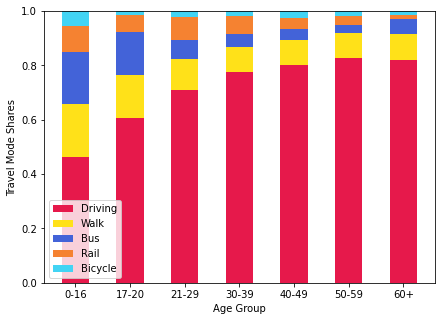

In [15]:
importlib.reload(plot)
results=dict.fromkeys(age)
for i in range(len(age)):
    results[age[i]]=freq_mode_age[age[i]]/freq_mode_age[age[i]].sum()

plot.Mode_Share_Group(results, freq_mode_age,figsize=(7,5))
plt.xlabel('Age Group')
plt.legend(loc='lower left')

plt.savefig('image\\share_age.png',bbox_inches='tight',dpi=300)

### Gender

In [16]:
gender=['Male','Female']
gender_num=[1,0]
freq_mode_gender=pd.DataFrame(columns=gender,index=range(1,6))
for i in range(len(gender)):
    freq_mode_gender[gender[i]]=data_non_stand[data_non_stand.Individual_gender_1==gender_num[i]].Mode.value_counts()
freq_mode_gender.index=travel_mode
freq_mode_gender=freq_mode_gender.reindex(['Driving','Walk','Bus','Rail','Bicycle'],axis = 'rows')
freq_mode_gender

Male  Female
Driving  61536   70085
Walk      7193    9456
Bus       3437    5430
Rail      4026    3389
Bicycle   2313     852

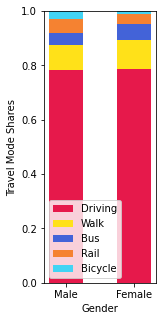

In [17]:
results=dict.fromkeys(gender)
for i in range(len(gender)):
    results[gender[i]]=freq_mode_gender[gender[i]]/freq_mode_gender[gender[i]].sum()

plot.Mode_Share_Group(results, freq_mode_gender,figsize=(2,5))
plt.xlabel('Gender')
plt.legend(loc='lower left')

plt.savefig('image\\share_gender.png',bbox_inches='tight',dpi=300)

### Travel Purpose

In [18]:
purp=['Commuting','Business','Education','Shopping','Personal\nbusiness','Leisure','Other']
purp_series=[data_non_stand.Trip_purpose_1,data_non_stand.Trip_purpose_2,data_non_stand.Trip_purpose_3,data_non_stand.Trip_purpose_4,
            data_non_stand.Trip_purpose_5,data_non_stand.Trip_purpose_6]
index=data_non_stand.index
freq_mode_purp=pd.DataFrame(columns=purp,index=range(1,6))
for i in range(len(purp)-1):
    freq_mode_purp[purp[i]]=data_non_stand[purp_series[i]==1].Mode.value_counts()
    index.drop(data_non_stand[purp_series[i]==1].index)
freq_mode_purp[purp[6]]=data_non_stand.loc[index].Mode.value_counts()
freq_mode_purp.index=travel_mode
freq_mode_purp=freq_mode_purp.reindex(['Driving','Walk','Bus','Rail','Bicycle'],axis = 'rows')
freq_mode_purp

Commuting  Business  Education  Shopping  Personal\nbusiness  \
Driving      24104      7080       8336     26846               13290   
Walk          1934       218       1566      2731                1167   
Bus           2358       217        997      2228                 864   
Rail          3777       827        399       319                 345   
Bicycle       1396        94        145       395                 160   

         Leisure   Other  
Driving    38463  131621  
Walk        2879   16649  
Bus         2034    8867  
Rail        1669    7415  
Bicycle      952    3165

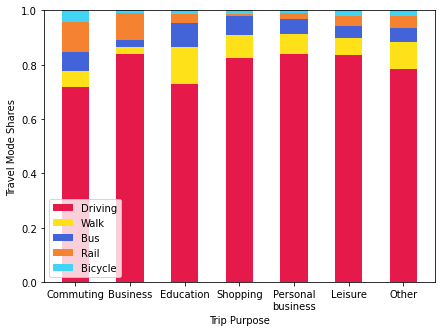

In [19]:
results=dict.fromkeys(purp)
for i in range(len(purp)):
    results[purp[i]]=freq_mode_purp[purp[i]]/freq_mode_purp[purp[i]].sum()

plot.Mode_Share_Group(results, freq_mode_purp,figsize=(7,5))
plt.xlabel('Trip Purpose')
plt.legend(loc='lower left')

plt.savefig('image\\share_purp.png',bbox_inches='tight',dpi=300)

## Correlation matrix of variables

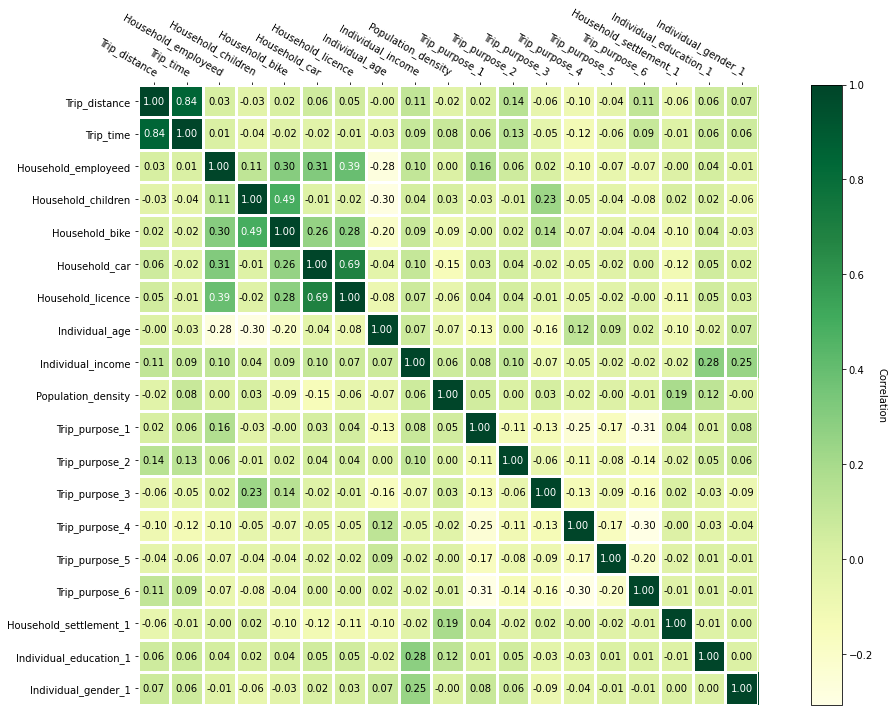

In [41]:
fig, ax = plt.subplots(figsize=(15, 10))

im, cbar = plot.heatmap(df.corr().values, fixed_effect, ax=ax,cmap="YlGn", cbarlabel="Correlation")
texts = plot.annotate_heatmap(im)

fig.tight_layout()
plt.savefig('image\\corr.png',bbox_inches='tight',dpi=300)

# Random Effect-Bayesian Neural Network (RE-BNN)

## Hyperparameter searching for RE-BNN

We use the standardized dataset and try different numbers of hidden units and different learning rates to find which combination of hyparameters leads to best predictive performance.

In [ ]:
# find the best parameter
learning_rate_list=[0.1,0.01, 1e-3, 1e-4]
n_hidden_list=[5,10,15, 25, 50, 100]

data_hp=data.sample(100000,random_state=42)
data_hp.reset_index(inplace=True)
accuracy_hp=np.zeros((len(learning_rate_list), len(n_hidden_list))) 

for i in range(len(learning_rate_list)):
    list1=[]
    for j in range(len(n_hidden_list)):
        Test_accuracy=nn.REBNN_MODEL(data_hp,f'data1{i}{j}',n_hidden=n_hidden_list[j],learning_rate=learning_rate_list[i],test=True)
        list1.append(Test_accuracy)
    accuracy_hp[i]=list1
    
pd.DataFrame(accuracy_hp).to_csv('./table/hp_searching.csv')

In [4]:
accuracy_hp=pd.read_csv('./table/hp_searching.csv',index_col=0).values
learning_rate_list=[0.1,0.01, 1e-3, 1e-4]
n_hidden_list=[5,10,15, 25, 50, 100]

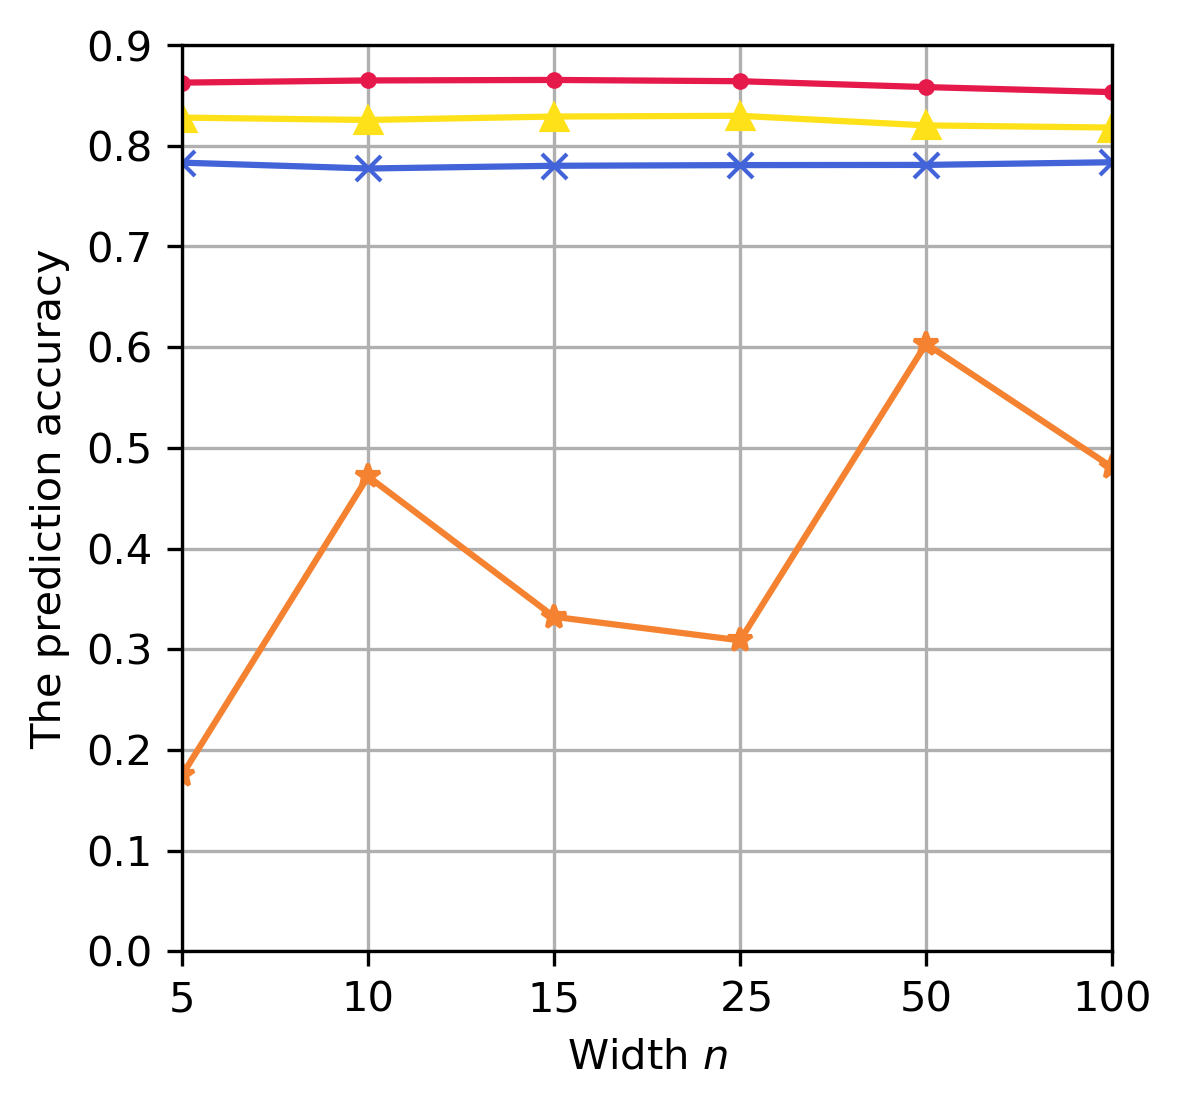

In [8]:
color=['#e6194B','#ffe119', '#4363d8', '#f58231', '#42d4f4', '#f032e6', 
       '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#000075']
linestyle=['.-','^-','x-','*-']

plt.figure(dpi=300,figsize=(4,4))


plt.ylim(ymax=0.9,ymin=0)
plt.xlim(0,len(n_hidden_list)-1)
for i in range(len(learning_rate_list)):
    plt.plot(range(len(n_hidden_list)),accuracy_hp[i],linestyle[i],c=color[i],label=f'LR:{learning_rate_list[i]}')
plt.xticks(range(len(n_hidden_list)),['5','10','15',' 25', '50', '100'])


plt.grid(True)
plt.xlabel(f'Width $n$')
plt.ylabel('The prediction accuracy')
# plt.title('(a) Standardisation',y=-0.25)

plt.savefig('./image/hp_test.png',bbox_inches='tight')

So we use 0.1 learning rate and 15 hidden units, and use standardised dataset.

In [13]:
# revise the defualt hyperparameter and reload the package for the training
import importlib
importlib.reload(nn)

<module 'nn' from 'J:\\term3\\dissertation\\nn.py'>

## Train RE-BNNs

In [40]:
# split the data by years
data2005=data[data.Year==2005].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2006=data[data.Year==2006].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2007=data[data.Year==2007].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2008=data[data.Year==2008].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2009=data[data.Year==2009].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2010=data[data.Year==2010].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2011=data[data.Year==2011].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2012=data[data.Year==2012].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2013=data[data.Year==2013].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2014=data[data.Year==2014].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2015=data[data.Year==2015].sort_values(by=['Mode','Household_region']).reset_index(drop=True)
data2016=data[data.Year==2016].sort_values(by=['Mode','Household_region']).reset_index(drop=True)

data_list=[data2005,data2006,data2007,data2008,data2009,data2010,data2011,data2012,data2013,data2014,data2015,data2016]

Train the models and extract the random effect parameters (non-standard and standard) of alteratives for each regions into lists.

In [ ]:
for _ in range(50):
    accuracy_rebnn=[]
    prob_rebnn_pre=[]
    prob_rebnn_true=[]
    result_para_rebnn=[]
    qb_r_standard=[]
    year=2005
    for j in data_list:
        Test_accuracy,probabilities_pre,probabilities_true,result_para=nn.REBNN_MODEL(j,f'data_rebnn{year}time{_+1}')
        accuracy_rebnn.append(Test_accuracy)
        prob_rebnn_pre.append(probabilities_pre)
        prob_rebnn_true.append(probabilities_true)
        result_para_rebnn.append(result_para)
        #standardise the parameters of the random effect variable 
        scaler = preprocessing.StandardScaler().fit(result_para[4])
        qb_r_standard.append(scaler.transform(result_para[4]))
        year+=1

    pd.DataFrame(accuracy_rebnn).to_csv(f'results\\rebnn\\train{_+1}\\accuracy_rebnn.csv')
    for i in range(len(years_str)):
        pd.DataFrame(prob_rebnn_pre[i]).to_csv(f'results\\rebnn\\train{_+1}\\prob_rebnn_pre{years_str[i]}.csv')
        pd.DataFrame(prob_rebnn_true[i]).to_csv(f'results\\rebnn\\train{_+1}\\prob_rebnn_true{years_str[i]}.csv')
        for j in range(len(result_para_rebnn[i])):
            pd.DataFrame(result_para_rebnn[i][j]).to_csv(f'results\\rebnn\\train{_+1}\\result_para_rebnn{i}{j}.csv')
        pd.DataFrame(qb_r_standard[i]).to_csv(f'results\\rebnn\\train{_+1}\\qb_r_standard{years_str[i]}.csv')

# Compared against BNN, DNN, and MNL models

## Bayesian Neural Network (BNN)

The BNN uses the same hyperparameters with RE-BNN.

In [ ]:
for _ in range(20,40):
    accuracy_bnn=[]
    prob_bnn_pre=[]
    result_para_bnn=[]
    year=2005
    for j in data_list:
        Test_accuracy,probabilities_pre,result_para=nn.BNN_MODEL(j,f'data_bnn{year}time{_+1}')
        accuracy_bnn.append(Test_accuracy)
        prob_bnn_pre.append(probabilities_pre)
        result_para_bnn.append(result_para)
        year+=1

    pd.DataFrame(accuracy_bnn).to_csv(f'results\\bnn\\train{_+1}\\accuracy_bnn.csv')
    for i in range(len(years_str)):
        pd.DataFrame(prob_bnn_pre[i]).to_csv(f'results\\bnn\\train{_+1}\\prob_bnn_pre{years_str[i]}.csv')
        for j in range(len(result_para_bnn[i])):
            pd.DataFrame(result_para_bnn[i][j]).to_csv(f'results\\bnn\\train{_+1}\\result_para_bnn{i}{j}.csv')

## Fully Connected Neural Network (DNN)

### Hyperparameter searching for DNN

In [ ]:
# find the best parameter
# Hyperparameter spaces is as same as RE-BNN except batchsize

learning_rate_list=[0.1,0.01, 1e-3, 1e-4]
n_hidden_list=[5,10,15, 25, 50, 100]
batch_size_list=[10,50,100]

data_hp=data.sample(100000,random_state=42)
data_hp.reset_index(inplace=True)
accuracy_test1_dnn=np.zeros((len(learning_rate_list), len(n_hidden_list),len(batch_size_list))) 
for i in range(len(learning_rate_list)):
    for j in range(len(n_hidden_list)):
        for k in range(len(batch_size_list)):
            Test_accuracy,probabilities,result_para=nn.DNN_MODEL(data_hp,f'searching{i}{j}{k}',n_hidden=n_hidden_list[j],learning_rate=learning_rate_list[i],batch_size=batch_size_list[k])
            accuracy_test1_dnn[i][j][k]=Test_accuracy


#save the test results
for i in range(len(learning_rate_list)):
    pd.DataFrame(accuracy_test1_dnn[i]).to_csv(f'./table/hp_searching_dnn_lr{learning_rate_list[i]}.csv')

In [9]:
learning_rate_list=[0.1,0.01, 1e-3, 1e-4]
n_hidden_list=[5,10,15, 25, 50, 100]
batch_size_list=[10,50,100]

# read the accuracy results from local
accuracy_hp_dnn=np.zeros((len(learning_rate_list), len(n_hidden_list),len(batch_size_list))) 
for i in range(len(learning_rate_list)):
    accuracy_hp_dnn[i]=pd.read_csv(f'./table/hp_searching_dnn_lr{learning_rate_list[i]}.csv',index_col=0).values

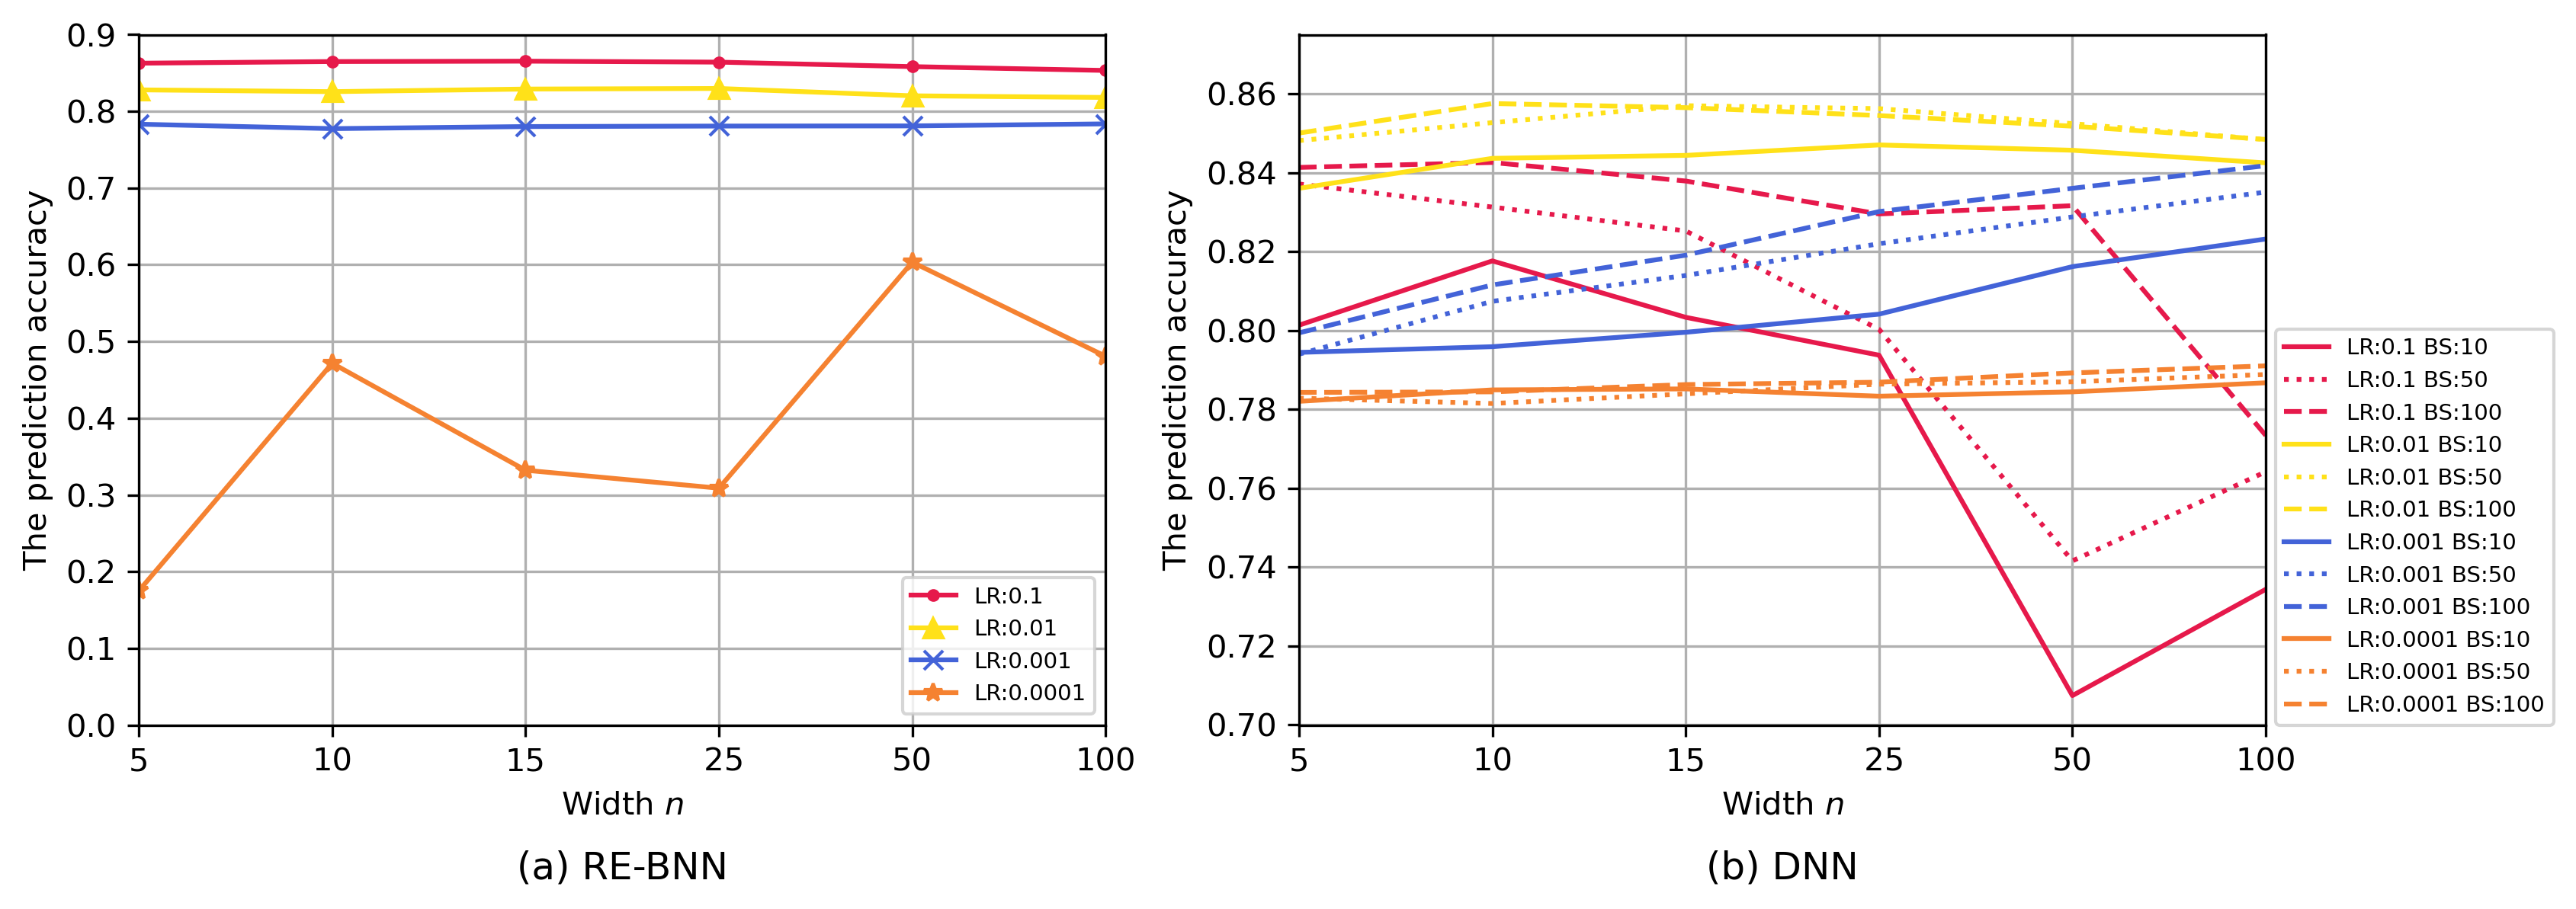

In [18]:
color=['#e6194B','#ffe119', '#4363d8', '#f58231', '#42d4f4', '#f032e6', 
       '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#000075']
linestyle=['.-','^-','x-','*-']

# color= ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd']
linestyle_batch=['-',':','--']

plt.figure(dpi=300,figsize=(12,4))


plt.subplot(121)
plt.ylim(ymax=0.9,ymin=0)
plt.xlim(0,len(n_hidden_list)-1)
for i in range(len(learning_rate_list)):
    plt.plot(range(len(n_hidden_list)),accuracy_hp[i],linestyle[i],c=color[i],label=f'LR:{learning_rate_list[i]}')
plt.xticks(range(len(n_hidden_list)),['5','10','15',' 25', '50', '100'])

plt.legend(prop = {'size':7})
plt.grid(True)
plt.xlabel(f'Width $n$')
plt.ylabel('The prediction accuracy')
plt.title('(a) RE-BNN',y=-0.25)


plt.subplot(122)
plt.xlim(0,len(n_hidden_list)-1)
plt.ylim(0.7,0.875)

for i in range(len(learning_rate_list)):
    for k in range(len(batch_size_list)):
        plt.plot(range(len(n_hidden_list)),accuracy_hp_dnn[i].T[k],
                 c=color[i],linestyle=linestyle_batch[k],
                 #alpha=0.8,
                 label=f'LR:{learning_rate_list[i]} BS:{batch_size_list[k]}')
#         for j in range(len(accuracy_test1_dnn[i])):
#             plt.text(range(len(n_hidden_list))[j],accuracy_test1_dnn[i][j][k],str(round(accuracy_test1_dnn[i][j][k],3)))
plt.xticks(range(len(n_hidden_list)),['5','10','15',' 25', '50', '100'])

plt.legend(
   bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0,
    prop = {'size':7}
)

# plt.legend()
plt.grid(True)
plt.xlabel(f'Width $n$')
plt.ylabel('The prediction accuracy')
plt.title('(b) DNN',y=-0.25)

plt.savefig('./image/hp_test.png',bbox_inches='tight')

Therefore,the hyperparameters we used to train DNN is LR:0.01,BS:100,width_n=10,standardisation=Ture

### Train DNNs

In [ ]:
for _ in range(50):
    accuracy_dnn=[]
    prob_dnn_pre=[]
    result_para_dnn=[]
    year=2005
    for j in data_list:
        Test_accuracy,probabilities_pre,result_para=nn.DNN_MODEL(j,f'data_dnn{year} time{_+1}')
        accuracy_dnn.append(Test_accuracy)
        prob_dnn_pre.append(probabilities_pre)
        result_para_dnn.append(result_para)
        year+=1

    pd.DataFrame(accuracy_dnn).to_csv(f'results\\dnn\\train{_+1}\\accuracy_dnn.csv')
    for i in range(len(years_str)):
        pd.DataFrame(prob_dnn_pre[i]).to_csv(f'results\\dnn\\train{_+1}\\prob_dnn_pre{years_str[i]}.csv')
        for j in range(len(result_para_dnn[i])):
            pd.DataFrame(result_para_dnn[i][j]).to_csv(f'results\\dnn\\train{_+1}\\result_para_dnn{i}{j}.csv')

## Multinomial Logit Model (MNL)

In [117]:
corr_choice_attribute=pd.DataFrame(columns=plot.get_modes(),index=nn.get_vars())

In [155]:
importlib.reload(nn)
# choose vars of each mode
data_test_mnl=data.sample(100000,random_state=42).reset_index()
data_test_mnl.drop(columns=['index','IndividualID','HouseholdID','Year','Household_region'],inplace=True)
mnl_col,corr_mnl=nn.get_vars_MNL(data_test_mnl)

Columns correlated with the alternatives Walk:
Mode_y                 1.000000
Household_car          0.128122
Trip_distance          0.119677
Household_licence      0.104553
Trip_purpose_1         0.073007
Trip_purpose_6         0.060728
Trip_purpose_2         0.054624
Household_employeed    0.049424
Individual_income      0.048711
Trip_purpose_3         0.044048
Name: Mode_y, dtype: float64
Columns selected in the utility function of Walk:
['Household_car', 'Trip_distance', 'Household_licence', 'Trip_time']
 
Columns correlated with the alternatives Bicycle:
Mode_y                    1.000000
Household_bike            0.077892
Trip_purpose_1            0.069661
Individual_gender_1       0.063832
Household_car             0.059819
Trip_distance             0.039636
Individual_age            0.029392
Household_licence         0.028681
Trip_purpose_4            0.027300
Individual_education_1    0.023555
Name: Mode_y, dtype: float64
Columns selected in the utility function of Bicycle:
[

In [160]:
for i in range(len(plot.get_modes())):
    corr_choice_attribute[plot.get_modes()[i]]=corr_mnl.T[i]

In [93]:
corr_choice_attribute=round(corr_choice_attribute,4)
corr_choice_attribute.to_csv('./table/corr_choice_attribute.csv')
corr_choice_attribute

Unnamed: 0    Walk  Bicycle  Car or van     Bus    Rail
0            Trip_distance -0.1197  -0.0396      0.0467 -0.0411  0.1631
1                Trip_time  0.0202  -0.0106     -0.1686  0.0788  0.2381
2      Household_employeed -0.0494   0.0138      0.0487 -0.0567  0.0331
3       Household_children -0.0060  -0.0008      0.0355 -0.0362 -0.0207
4           Household_bike -0.0324   0.0779      0.0726 -0.0991 -0.0358
5            Household_car -0.1281  -0.0598      0.2842 -0.2291 -0.0822
6        Household_licence -0.1046  -0.0287      0.2227 -0.2158 -0.0252
7           Individual_age -0.0416  -0.0294      0.1207 -0.0748 -0.0800
8        Individual_income -0.0487   0.0093      0.0380 -0.0900  0.0997
9       Population_density  0.0153   0.0208     -0.2319  0.1538  0.2651
10          Trip_purpose_1 -0.0730   0.0697     -0.0596  0.0369  0.1446
11          Trip_purpose_2 -0.0546  -0.0089      0.0385 -0.0296  0.0449
12          Trip_purpose_3  0.0440  -0.0046     -0.0613  0.0604 -0.0088
13          Trip_purpose_4 -0.0104  -0.0273      0.0252  0.0382 -0.0666
14          Trip_purpose_5 -0.0157  -0.0156      0.0267  0.0069 -0.0309
15          Trip_purpose_6 -0.0607   0.0112      0.0660 -0.0308 -0.0173
16  Household_settlement_1  0.0438   0.0203     -0.1147  0.0826  0.0604
17  Individual_education_1 -0.0063   0.0236     -0.0277 -0.0448  0.1085
18     Individual_gender_1 -0.0178   0.0638     -0.0049 -0.0342  0.0359

In [ ]:
# calibrate the model
accuracy_mnl=[]
prob_mnl_pre=[]
for i in data_list:
    acc,pred=nn.MNL_MODEL(i,mnl_col)
    accuracy_mnl.append(acc)
    prob_mnl_pre.append(pred)
    
pd.DataFrame(accuracy_mnl).to_csv('results\\mnl\\accuracy_mnl.csv')
for i in range(len(years_str)):
    pd.DataFrame(prob_mnl_pre[i]).to_csv(f'results\\mnl\\prob_mnl_pre{years_str[i]}.csv')

# Results and analysis

In [28]:
import importlib
importlib.reload(analysis)

<module 'analysis' from '/home/yutong/RE-BNN/analysis.py'>

In [3]:
#before analysis, read the training results and the parameter of each model

#rebnn
rebnn_result=analysis.training_result_rebnn()
accuracy_rebnn_50 = rebnn_result[0]
prob_rebnn_pre_50 = rebnn_result[1]
prob_rebnn_true_50 = rebnn_result[2]
result_para_rebnn_50 = rebnn_result[3]
qb_r_standard_50 = rebnn_result[4]

# bnn
bnn_result=analysis.training_result_bnn()
accuracy_bnn_50 = bnn_result[0]
prob_bnn_pre_50 = bnn_result[1]
result_para_bnn_50 = bnn_result[2]

#dnn
dnn_result=analysis.training_result_dnn()
accuracy_dnn_50 = dnn_result[0]
prob_dnn_pre_50 = dnn_result[1]
result_para_dnn_50 = dnn_result[2]

#mnl
mnl_result=analysis.training_result_mnl_mixed()
accuracy_mnl=mnl_result[0]
prob_mnl_pre=mnl_result[1]
mnl_col=mnl_result[2]

# mixed logit model
mixed_result=analysis.training_result_mnl_mixed(model='mixed')
accuracy_mixed=mixed_result[0]
prob_mixed_pre=mixed_result[1]
mixed_col=mixed_result[2]

## Predictive accuracy

### Predictive performances in different year data

For each ML model, we trains 50 times.

In [7]:
print(f'The max in RE-BNN:{max(np.mean(accuracy_rebnn_50,axis=0))}')
print(f'The max in BNN:{max(np.mean(accuracy_bnn_50,axis=0))}')
print(f'The max in DNN:{max(np.mean(accuracy_dnn_50,axis=0))}')
print(f'The max in MNL:{max(accuracy_mnl.T[0])}')
print(f'The max in Mixed:{max(accuracy_mixed.T[0])}')

The max in RE-BNN:0.8715384006500244
The max in BNN:0.8711025857925415
The max in DNN:0.8656579327583312
The max in MNL:0.7433825729753257
The max in Mixed:0.8410185260752469


In [8]:
print(f'The min in RE-BNN:{min(np.mean(accuracy_rebnn_50,axis=0))}')
print(f'The min in BNN:{min(np.mean(accuracy_bnn_50,axis=0))}')
print(f'The min in DNN:{min(np.mean(accuracy_dnn_50,axis=0))}')
print(f'The min in MNL:{min(accuracy_mnl.T[0])}')
print(f'The min in Mixed:{min(accuracy_mixed.T[0])}')

The min in RE-BNN:0.8605962276458741
The min in BNN:0.8612586224079132
The min in DNN:0.8494245862960815
The min in MNL:0.7277064538514921
The min in Mixed:0.8272033310201249


Now we plot their accuracy in each year testing set. Each training result is represented by the curve with low alpha value and the avarage accuracy in each year testing set is represented by the curve with high alpha value.

In [13]:
accuracy_df=pd.DataFrame(index=['RE-BNN','BNN','DNN','MNL','MXL'],columns=years_str)
accuracy_df.iloc[0]=np.round(np.mean(accuracy_rebnn_50,axis=0),3)
accuracy_df.iloc[1]=np.round(np.mean(accuracy_bnn_50,axis=0),3)
accuracy_df.iloc[2]=np.round(np.mean(accuracy_dnn_50,axis=0),3)
accuracy_df.iloc[3]=np.round(accuracy_mnl.T[0],3)
accuracy_df.iloc[4]=np.round(accuracy_mixed.T[0],3)
accuracy_df.to_csv('./table/accuracy.csv')
accuracy_df

2005   2006   2007   2008   2009   2010   2011   2012   2013   2014  \
RE-BNN  0.872  0.867  0.866  0.865  0.862  0.864  0.865  0.865  0.864  0.861   
BNN     0.871  0.868  0.867  0.864  0.861  0.863  0.866  0.865  0.865  0.861   
DNN     0.866  0.862   0.86  0.857  0.854  0.858  0.857  0.858  0.858  0.849   
MNL     0.743  0.742  0.738  0.735  0.731  0.742  0.733  0.732   0.73  0.728   
MXL     0.841  0.837  0.836   0.83   0.83  0.832   0.83  0.834  0.833  0.827   

         2015   2016  
RE-BNN  0.861  0.863  
BNN     0.861  0.863  
DNN     0.851  0.855  
MNL     0.732  0.741  
MXL     0.829  0.833

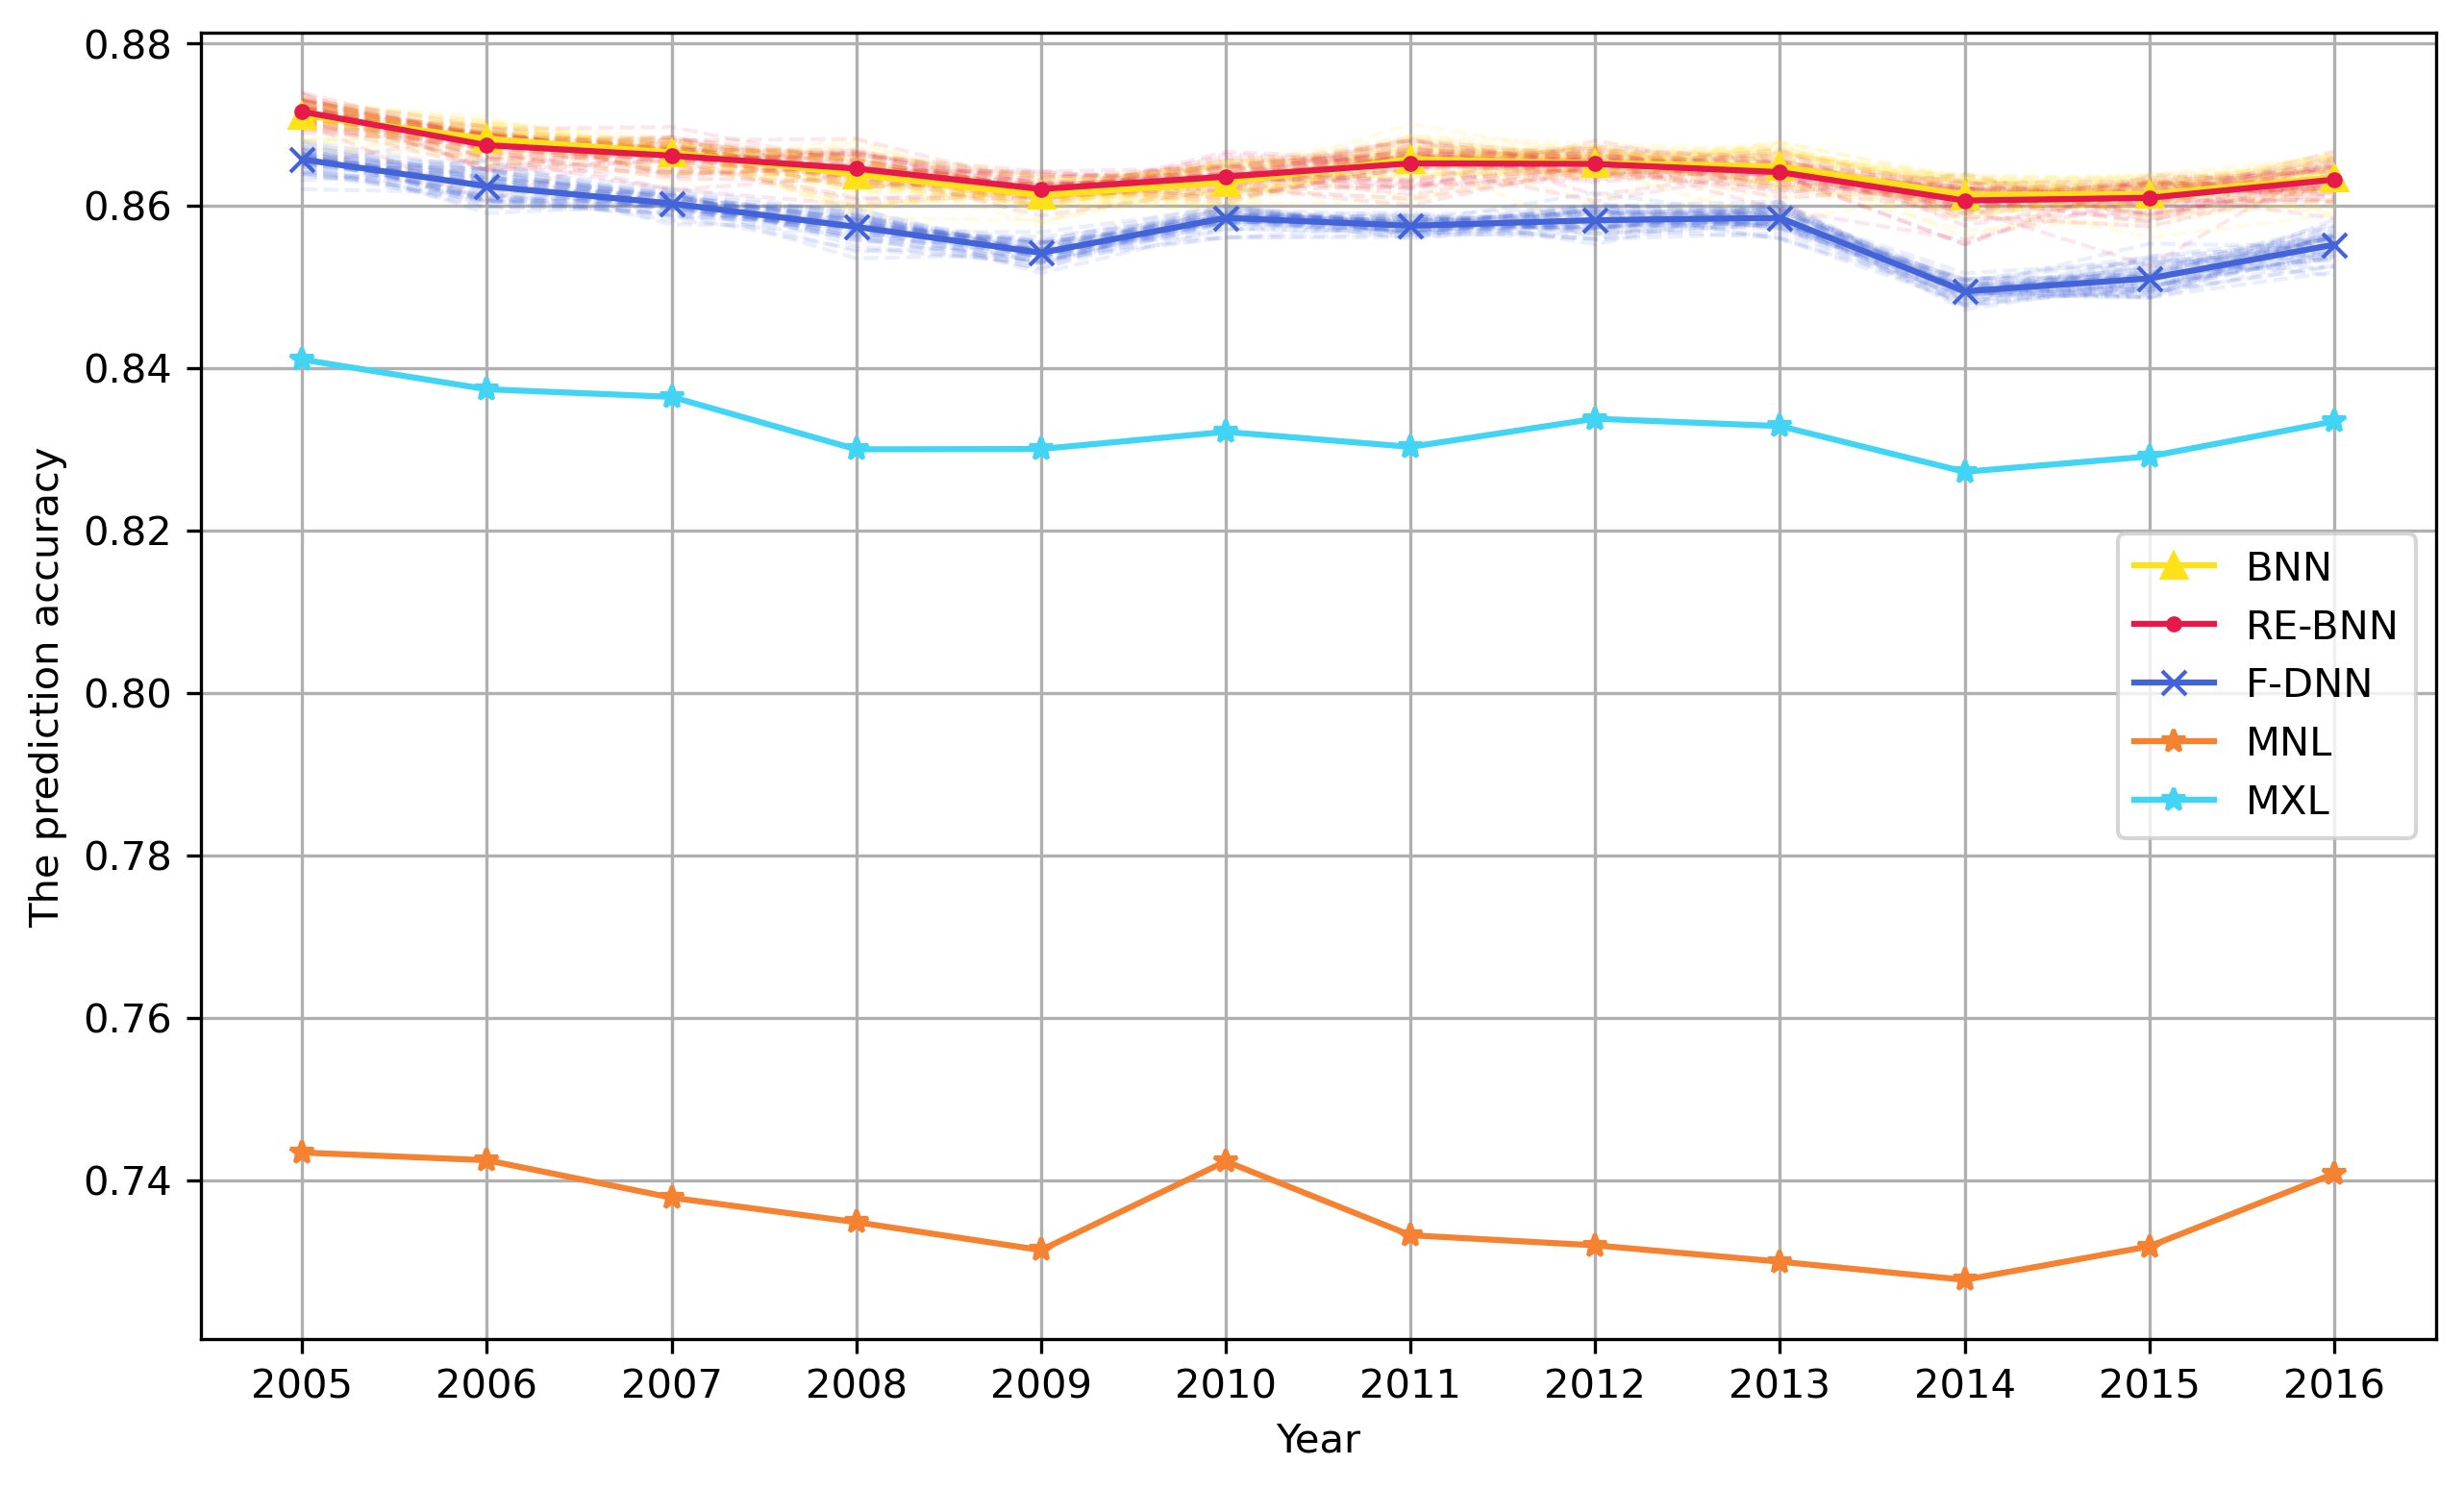

In [14]:
color=['#e6194B','#ffe119', '#4363d8', '#f58231', '#42d4f4', '#f032e6', 
       '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#000075']
linestyle=['.-','^-','x-','*-']

plt.figure(dpi=300,figsize=(10,6))

#print each training result
for _ in range(50):
    plt.plot(accuracy_rebnn_50[_],'--',alpha=0.1,linewidth=1,c=color[0])
    plt.plot(accuracy_bnn_50[_],'--',alpha=0.1,linewidth=1,c=color[1])
    plt.plot(accuracy_dnn_50[_],'--',alpha=0.1,linewidth=1,c=color[2])
    
#print average
plt.plot(np.mean(accuracy_bnn_50,axis=0),linestyle[1],alpha=1,label='BNN',c=color[1])
plt.plot(np.mean(accuracy_rebnn_50,axis=0),linestyle[0],alpha=1,label='RE-BNN',c=color[0])
plt.plot(np.mean(accuracy_dnn_50,axis=0),linestyle[2],alpha=1,label='F-DNN',c=color[2])
plt.plot(accuracy_mnl,linestyle[3],alpha=1,label='MNL',c=color[3])
plt.plot(accuracy_mixed,linestyle[3],alpha=1,label='MXL',c=color[4])
    
plt.xticks(range(12),['2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016'])
plt.xlabel('Year')
plt.ylabel('The prediction accuracy')
plt.grid()
plt.legend()
plt.savefig('./image/Comparision of the predictive performance.png',dpi=300)

### Predictive performances in different regions

We choose the result trainded by one year dataset (2016) and test the accuracy in different region.

In [15]:
# read the dataset(use to extract the region information of each observation)
data2016=analysis.dataset_year(2016)

In [ ]:
year='2016'

#the ture mode choice in 2016 testing set
acc_ture=prob_rebnn_true_50[0][year]

# create three dataframes to store accucry values in different regions
acc_rebnn=pd.DataFrame(columns=plot.get_region(),index=range(50))
acc_bnn=pd.DataFrame(columns=plot.get_region(),index=range(50))
acc_dnn=pd.DataFrame(columns=plot.get_region(),index=range(50))
acc_mnl=pd.DataFrame(columns=plot.get_region())
acc_mixed=pd.DataFrame(columns=plot.get_region())

for _ in range(50):
    acc_rebnn.loc[_]=analysis.acc_region(data2016, prob_rebnn_pre_50[_][year],acc_ture)
    acc_bnn.loc[_]=analysis.acc_region(data2016, prob_bnn_pre_50[_][year],acc_ture)
    acc_dnn.loc[_]=analysis.acc_region(data2016, prob_dnn_pre_50[_][year],acc_ture)

acc_mnl.loc[0]=analysis.acc_region(data2016, prob_mnl_pre[year],acc_ture)
acc_mixed.loc[0]=analysis.acc_region(data2016, prob_mixed_pre[year],acc_ture)


In [41]:
acc_rebnn=pd.read_csv('./results/acc_region_rebnn.csv')
acc_rebnn.drop(columns='Unnamed: 0',inplace=True)

acc_bnn=pd.read_csv('./results/acc_region_bnn.csv')
acc_bnn.drop(columns='Unnamed: 0',inplace=True)

acc_dnn=pd.read_csv('./results/acc_region_dnn.csv')
acc_dnn.drop(columns='Unnamed: 0',inplace=True)

acc_mnl=pd.read_csv('./results/acc_region_mnl.csv')
acc_mnl.drop(columns='Unnamed: 0',inplace=True)

acc_mixed=pd.read_csv('./results/acc_region_mixed.csv')
acc_mixed.drop(columns='Unnamed: 0',inplace=True)

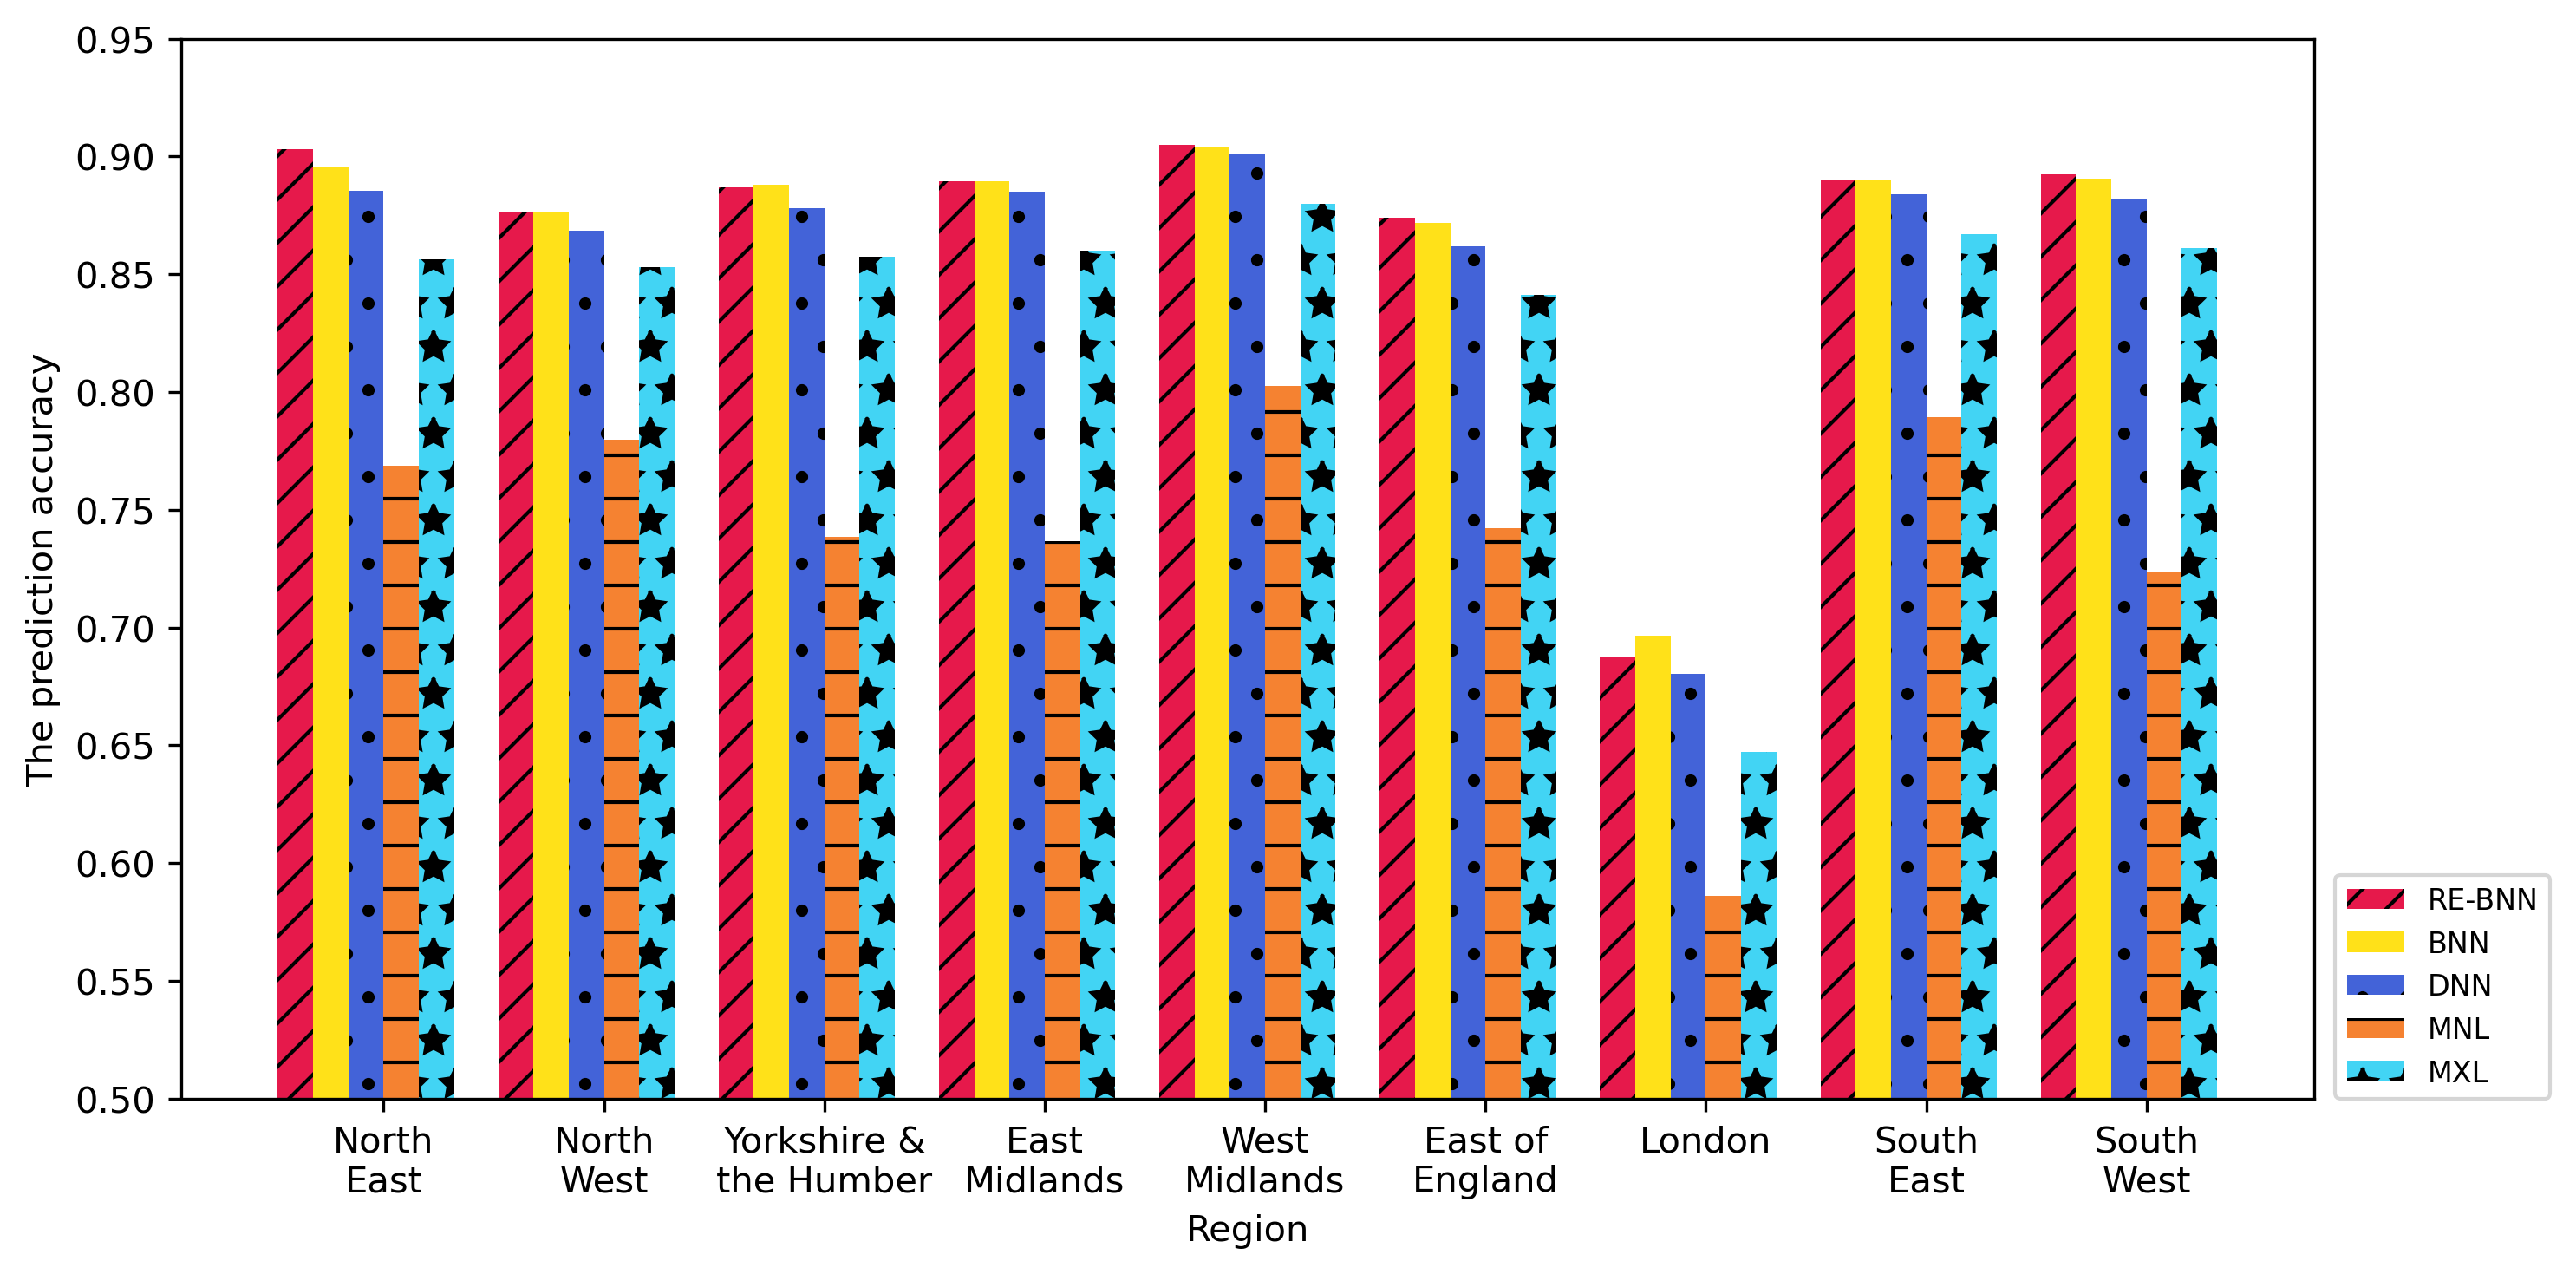

In [53]:
labels = ['North\nEast', 'North\nWest', 'Yorkshire &\nthe Humber'
        , 'East\nMidlands', 'West\nMidlands', 'East of\nEngland', 'London', 'South\nEast', 'South\nWest']
x1 = np.mean(acc_rebnn.values,axis=0)
x2 = np.mean(acc_bnn.values,axis=0)
x3=np.mean(acc_dnn.values,axis=0)
x4=acc_mnl.loc[0].values
x5=acc_mixed.loc[0].values

x = np.arange(len(labels))  # the label locations
width = 0.8  # the width of the bars
color=['#e6194B','#ffe119', '#4363d8', '#f58231','#42d4f4']
hatch=['//', '','.', '-','*']

fig, ax = plt.subplots(dpi=300,figsize=(10,5))
plt.ylim(0.5,0.95)
ax.bar(x - width * 5/10, x1, width/5, label='RE-BNN',hatch=hatch[0],color=color[0])
ax.bar(x - width* 3/10, x2, width/5, label='BNN',hatch=hatch[1],color=color[1])
ax.bar(x - width/10, x3, width/5, label='DNN',hatch=hatch[2],color=color[2])
ax.bar(x + width/10, x4, width/5, label='MNL',hatch=hatch[3],color=color[3])
ax.bar(x + width* 3/10, x5, width/5, label='MXL',hatch=hatch[4],color=color[4])

plt.xlabel('Region')
plt.ylabel('The prediction accuracy')

ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.legend(
   bbox_to_anchor=(1.01, 0), loc=3, borderaxespad=0,
    prop = {'size':8}
)

fig.tight_layout()

plt.savefig('./image/acc_region.png')

## Exploration of random effect parameters of different regions

Now we plot the region-sepcific parameter values for different alternatives, which can be regarded as the offset utility and be used to compare the travel mode choice preferences across regions.

### For a single year

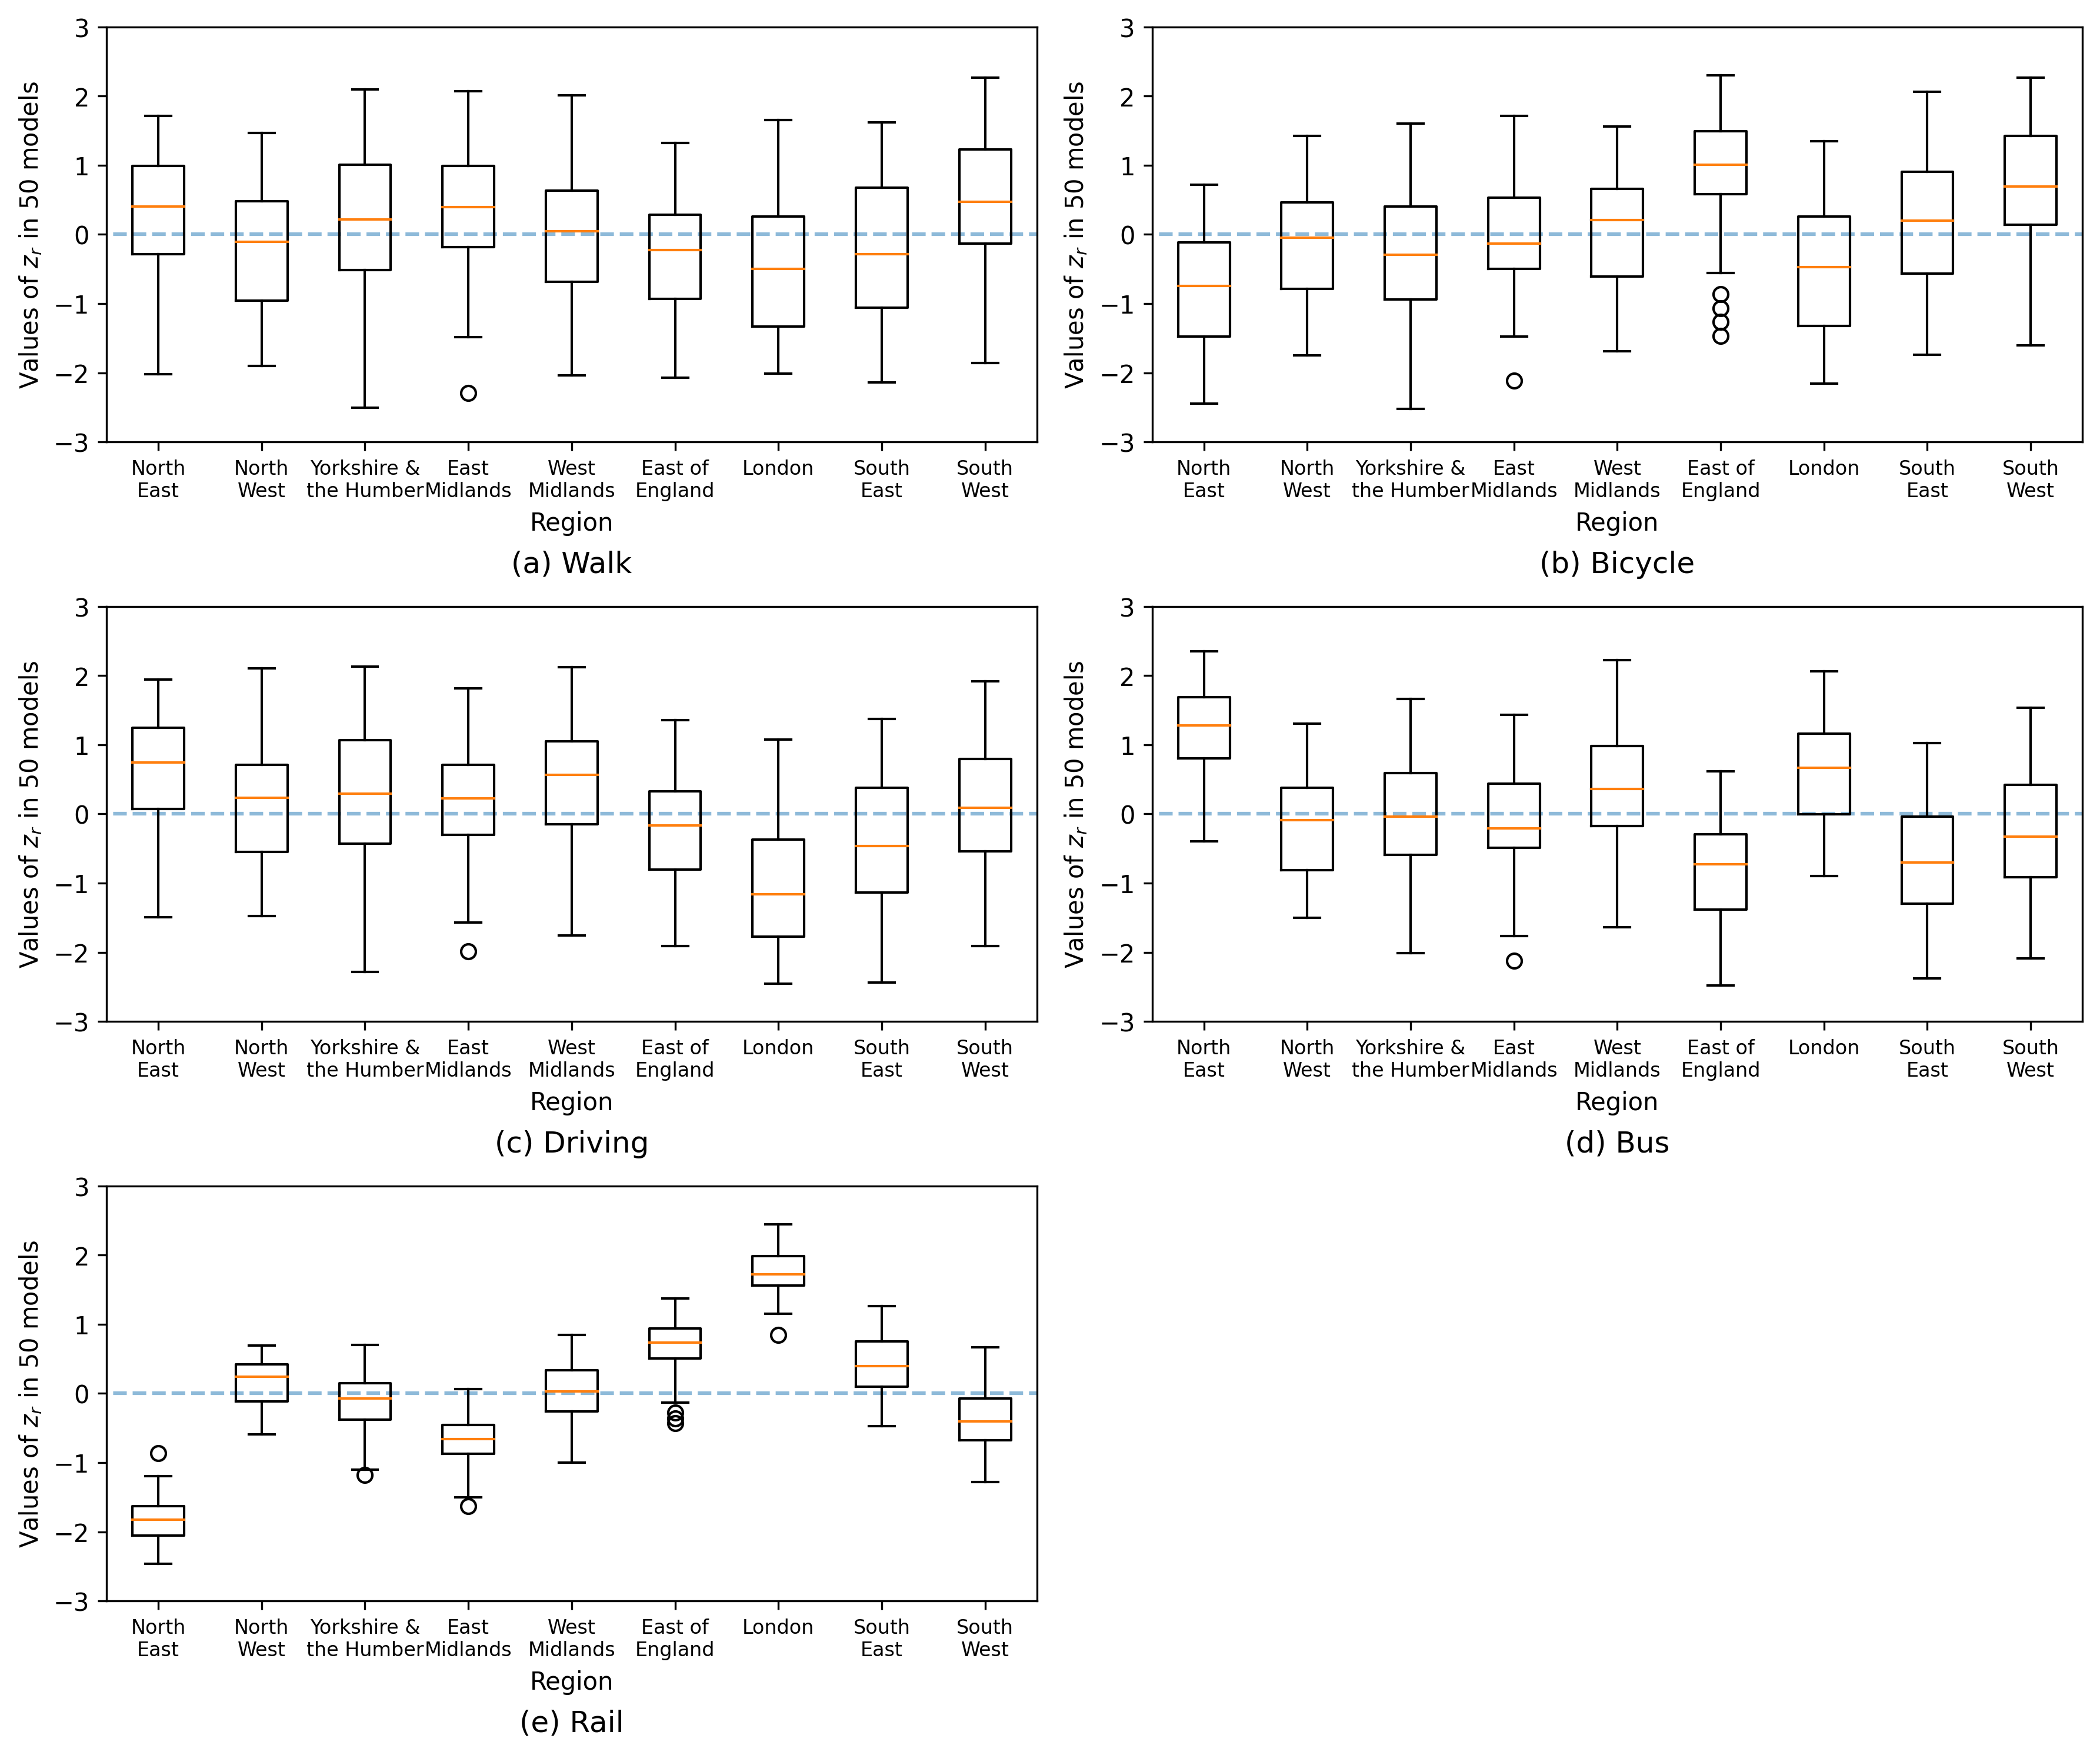

In [21]:
# plot
plot.Mode_in_Region_Plot_Stand(qb_r_standard_50,num_model=50,year='2016')
plt.savefig(f'image/Zr_stand.png', dpi=300)

### For all years

Now we use the average value (standardised) of 50 models and plot them trained by different year dataset. The length of the boxes represents the degree of variation of this alternative preference in the time period.

In [55]:
a = np.zeros((50,len(years_str),len(region_name),len(travel_mode)))
for _ in range(50):
    for year in range(len(years_str)):
        a[_][year]=qb_r_standard_50[_][year]

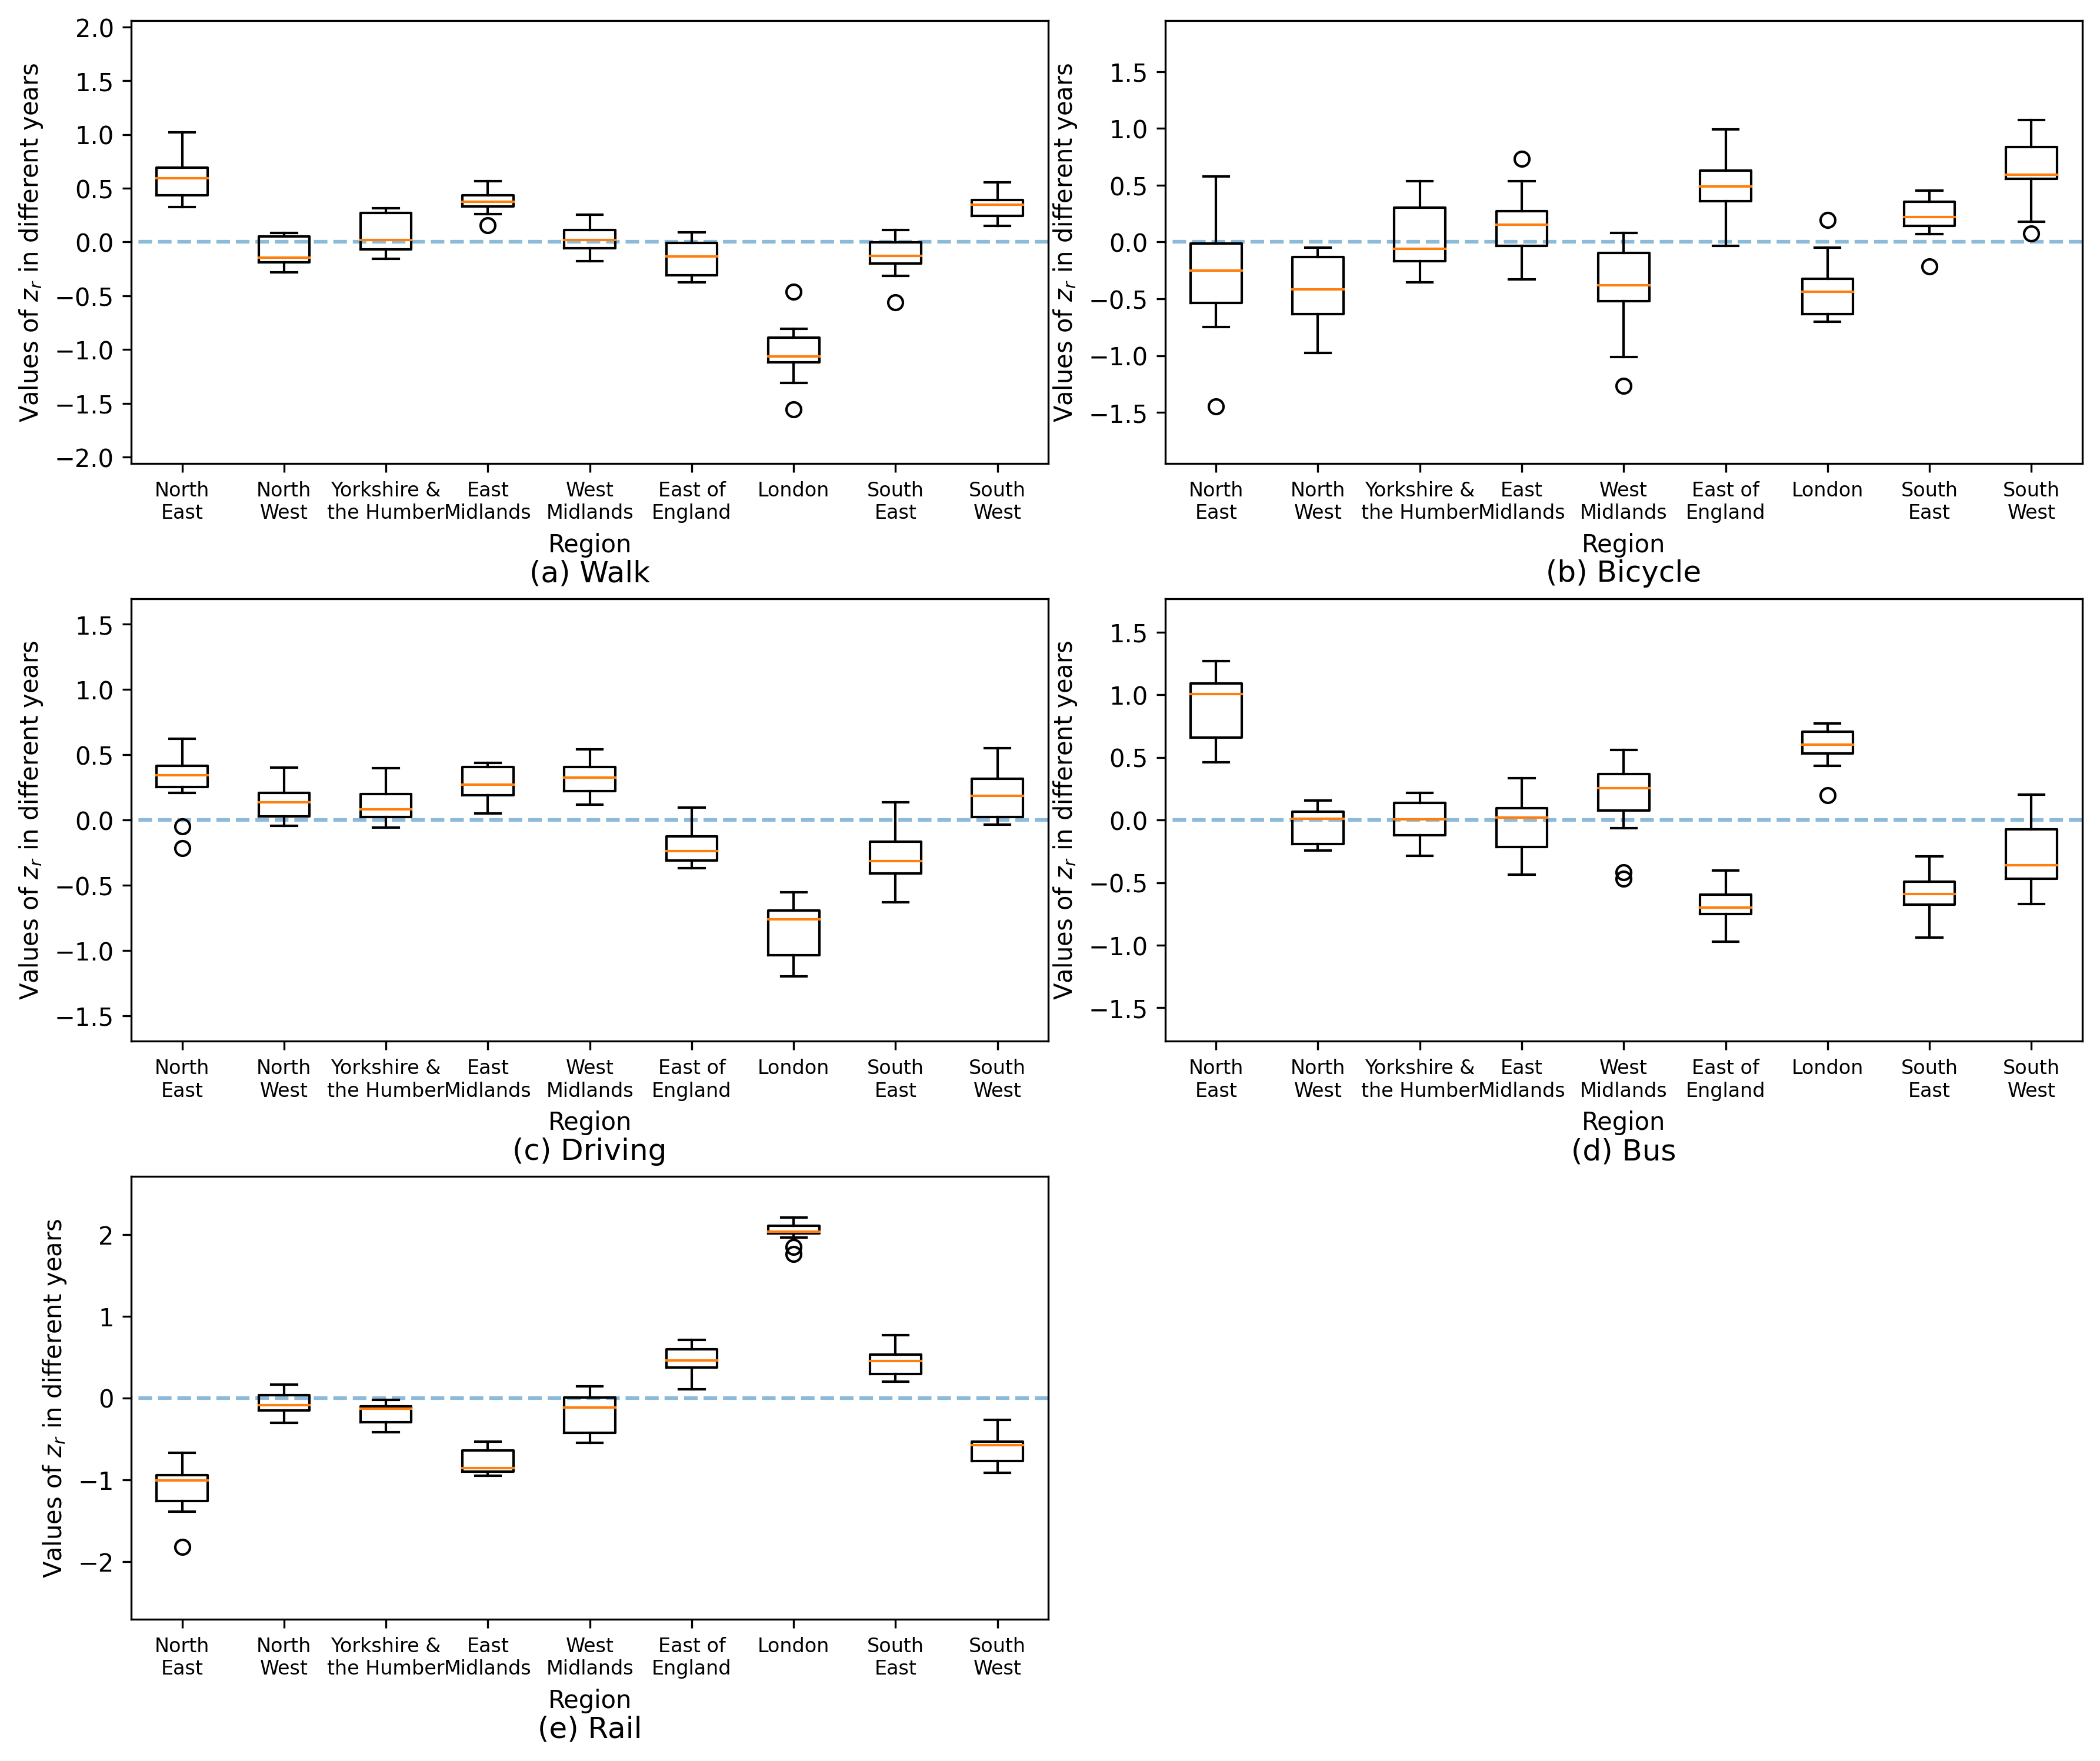

In [60]:
plot.Mode_in_Region_Plot_Stand_ave(a)
plt.savefig(f'image/Zr_variation by years.png', dpi=300)

## Probability function

This section we plot the choice probability functions with `Trip_time`.

In [60]:
import util
importlib.reload(util)

<module 'util' from '/home/yutong/RE-BNN/util.py'>

In [ ]:
#Parameter

#the variable that we want to be the x-axis
var_name='Trip_time'
var=fixed_effect.index(var_name)

#set the xsticks
xticks1_max=data[fixed_effect[var]].max()/8
xticks2_max=data_non_stand[fixed_effect[var]].max()/8
xticks_num=[0,xticks1_max/5,xticks1_max*2/5,xticks1_max*3/5,xticks1_max*4/5,xticks1_max]
xticks=[0,xticks2_max/5,xticks2_max*2/5,xticks2_max*3/5,xticks2_max*4/5,xticks2_max]

#set the ymax and ymin
ymax=1
ymin=0

# x
x=np.arange(0,xticks1_max,0.1)

#if we use scipy.signal.savgol_filter() to smooth the curves
window_length=5
polyorder=1

#the variables in RE-BNN model
vars_rebnn=util.config['experiments']['variables']
vars_rebnn.remove('Population_density')

year=years_str.index('2016')
# hold all other variables constant as their mean values
vars_mean_rebnn=list(data_list[year][vars_rebnn].mean())
vars_mean=list(data_list[year][fixed_effect].mean())

y_ave=np.zeros((len(years_str),len(travel_mode),len(x)))

#color for regions and modes
color_mode= ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd']
color_region= plt.get_cmap('jet')(np.linspace(0.1, 0.9, len(region_name)))

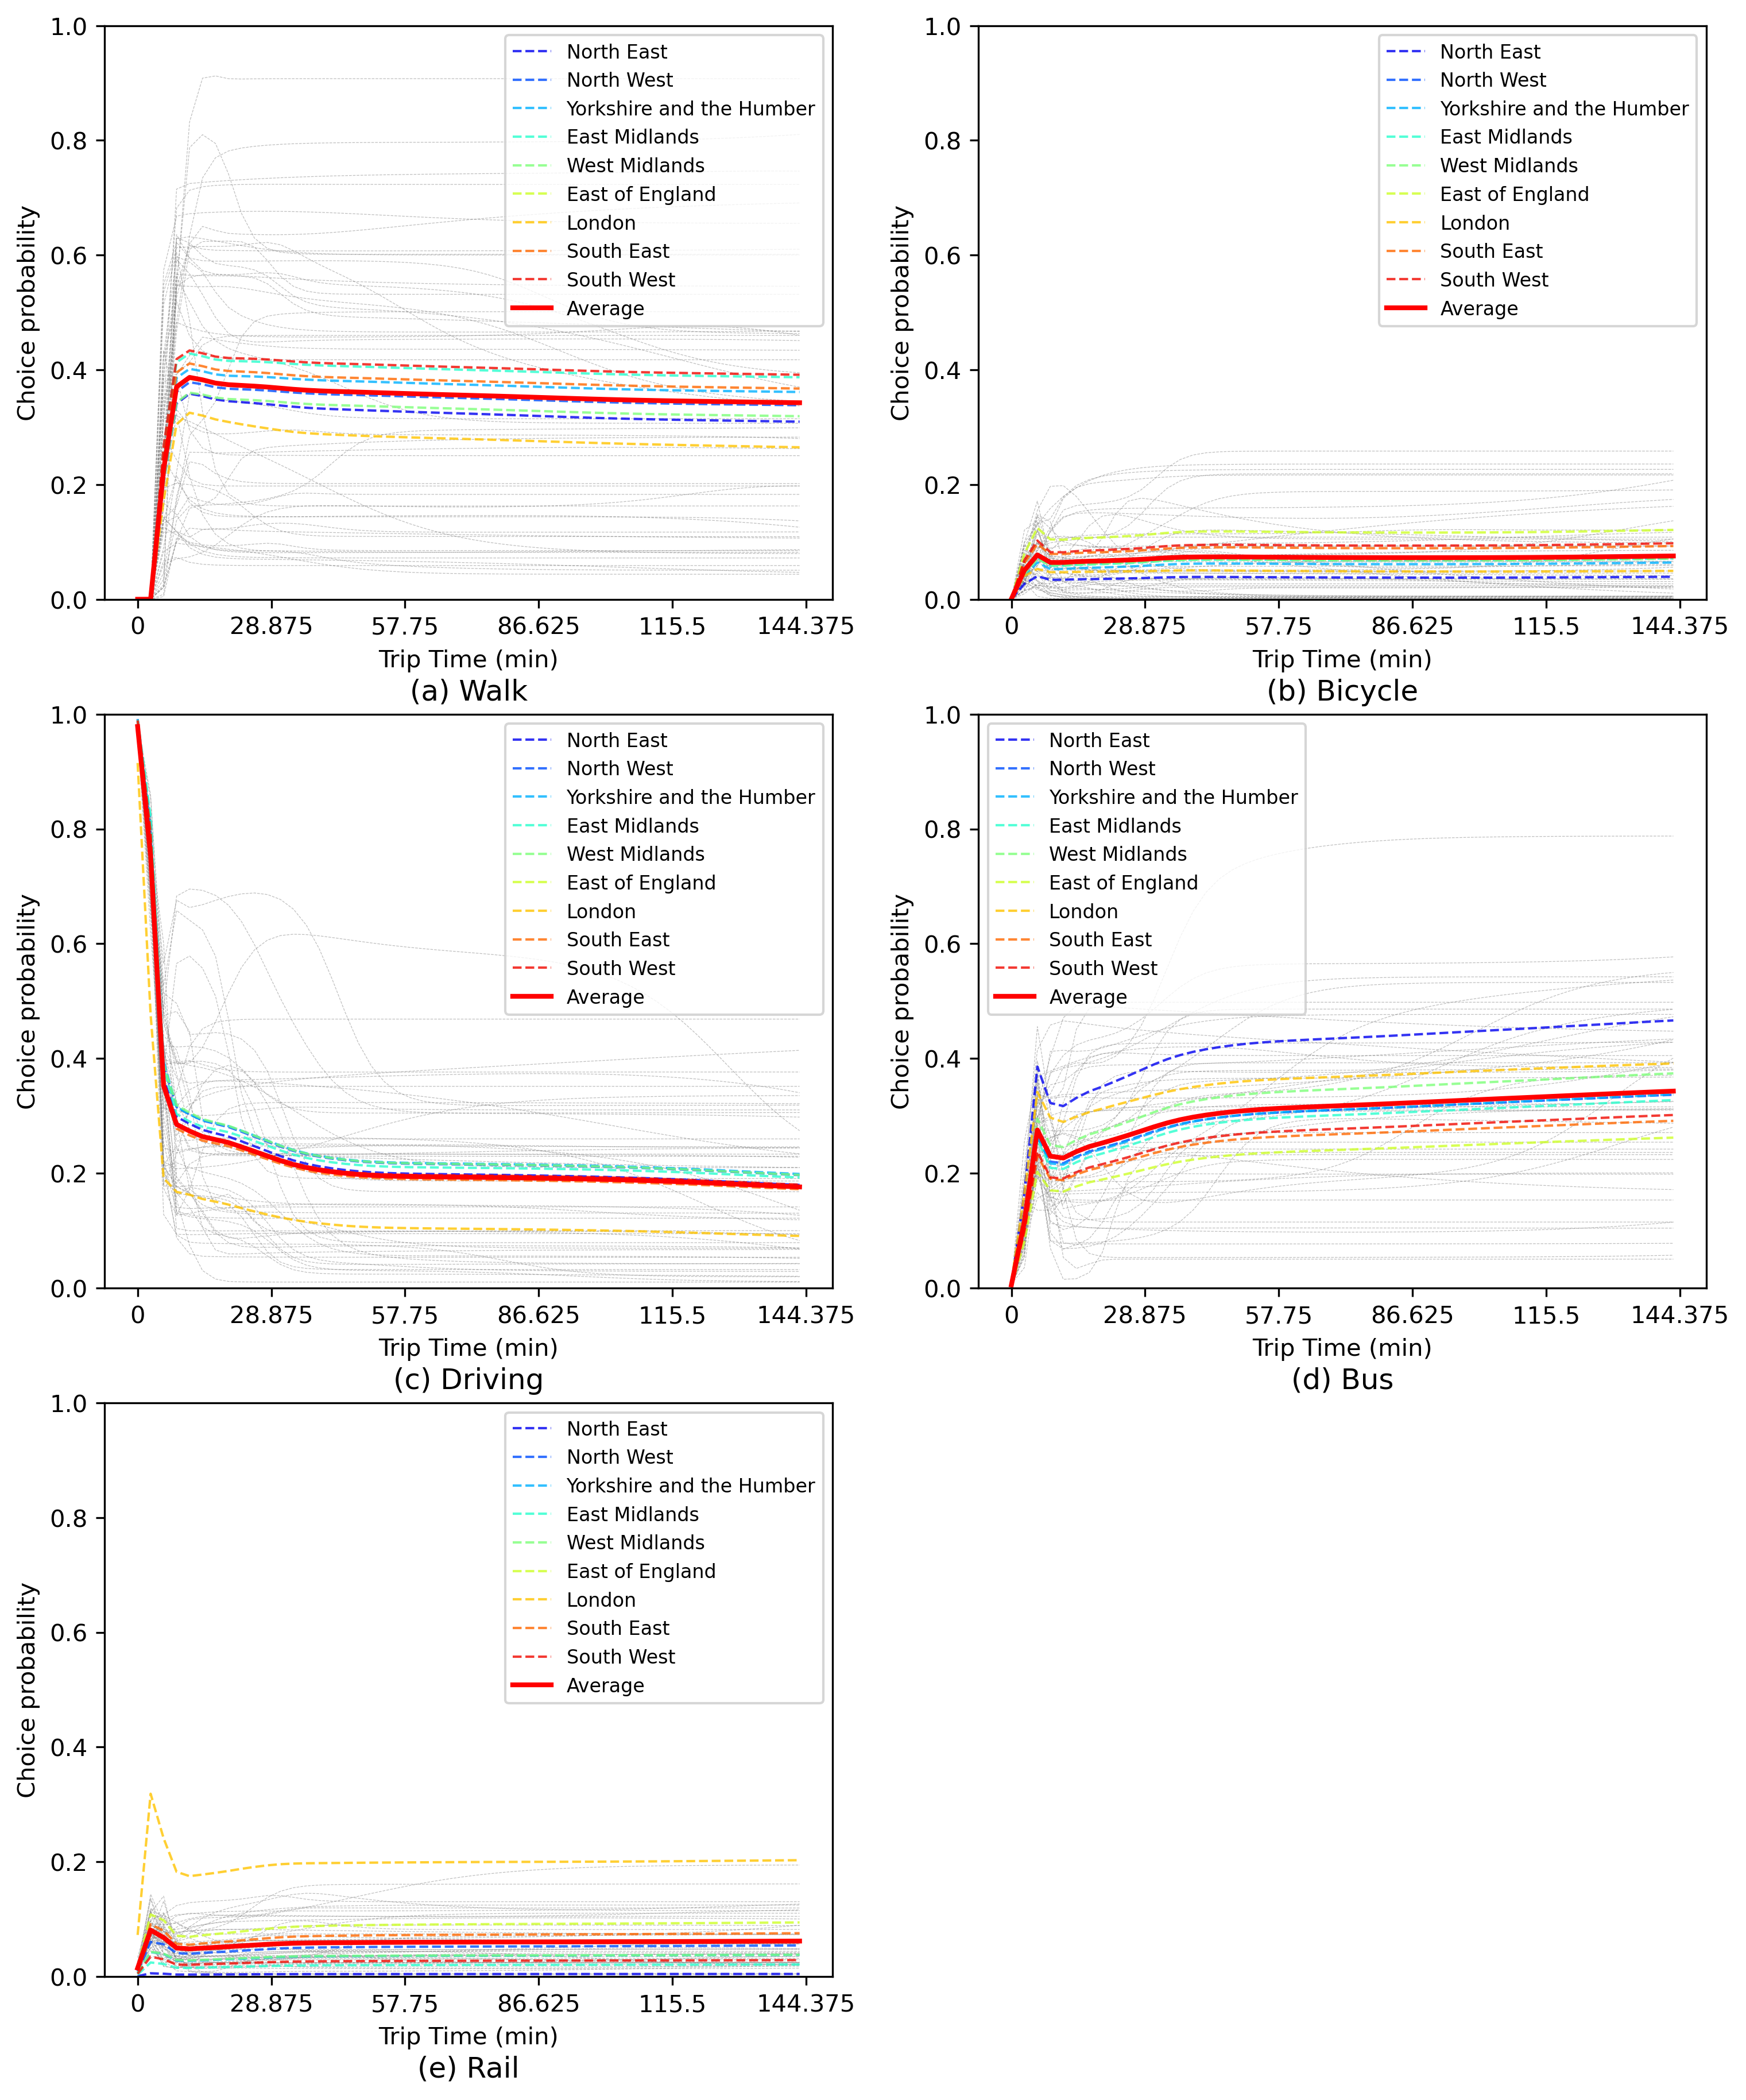

In [54]:
#the year we want to plot
year=years_str.index('2016')

# set the color and label and the linestyles
seq=['a','b','c','d','e']
ave_color='red'
linestyle='--'

#plot
fig=plt.figure(dpi=300,figsize=(12,15)) 

y_region=np.zeros((50,len(region_name),len(x)))
y_ave=np.zeros((50,len(x)))

for mode in range(len(travel_mode)):
    fig.add_subplot(3,2,mode+1)
    plt.ylim(ymax=ymax,ymin=ymin)
    #plot regional average of each training result
    for _ in range(50):
        for j in range(len(region_name)):
            y=analysis.prob_function_rebnn(x,years_str[year],result_para_rebnn_50[_],var,mode,region=j,vars_mean=vars_mean_rebnn)
#             plt.plot(x,y,linestyle=linestyle,linewidth=0.5,alpha=0.1,c='grey')
            y_region[_][j]=y
        y_ave[_]=np.mean(y_region[_],axis=0)
        plt.plot(x,y_ave[_],linestyle=linestyle,linewidth=0.3,alpha=0.5,c='grey')
        
    #plot rverage curves of training results in different regions
    for j in range(len(region_name)): 
        y=np.mean(y_region,axis=0)[j]
        plt.plot(x,y,linestyle=linestyle,linewidth=1,alpha=0.8,label=region_name[j],c=color_region[j])
    y=np.mean(y_ave,axis=0)
    plt.plot(x,y,linewidth=2,label='Average',c='red')
    plt.xlabel('Trip Time (min)')
    plt.ylabel('Choice probability')
    plt.xticks(xticks_num,xticks)
    plt.title(f'({seq[mode]}) {travel_mode[mode]}',y=-0.2)
    plt.legend(loc = 0, prop = {'size':8})

plt.savefig(f'./image/Probability functions of RE-BNN learned by {years_str[year]} training set in different regions.png', dpi=300)

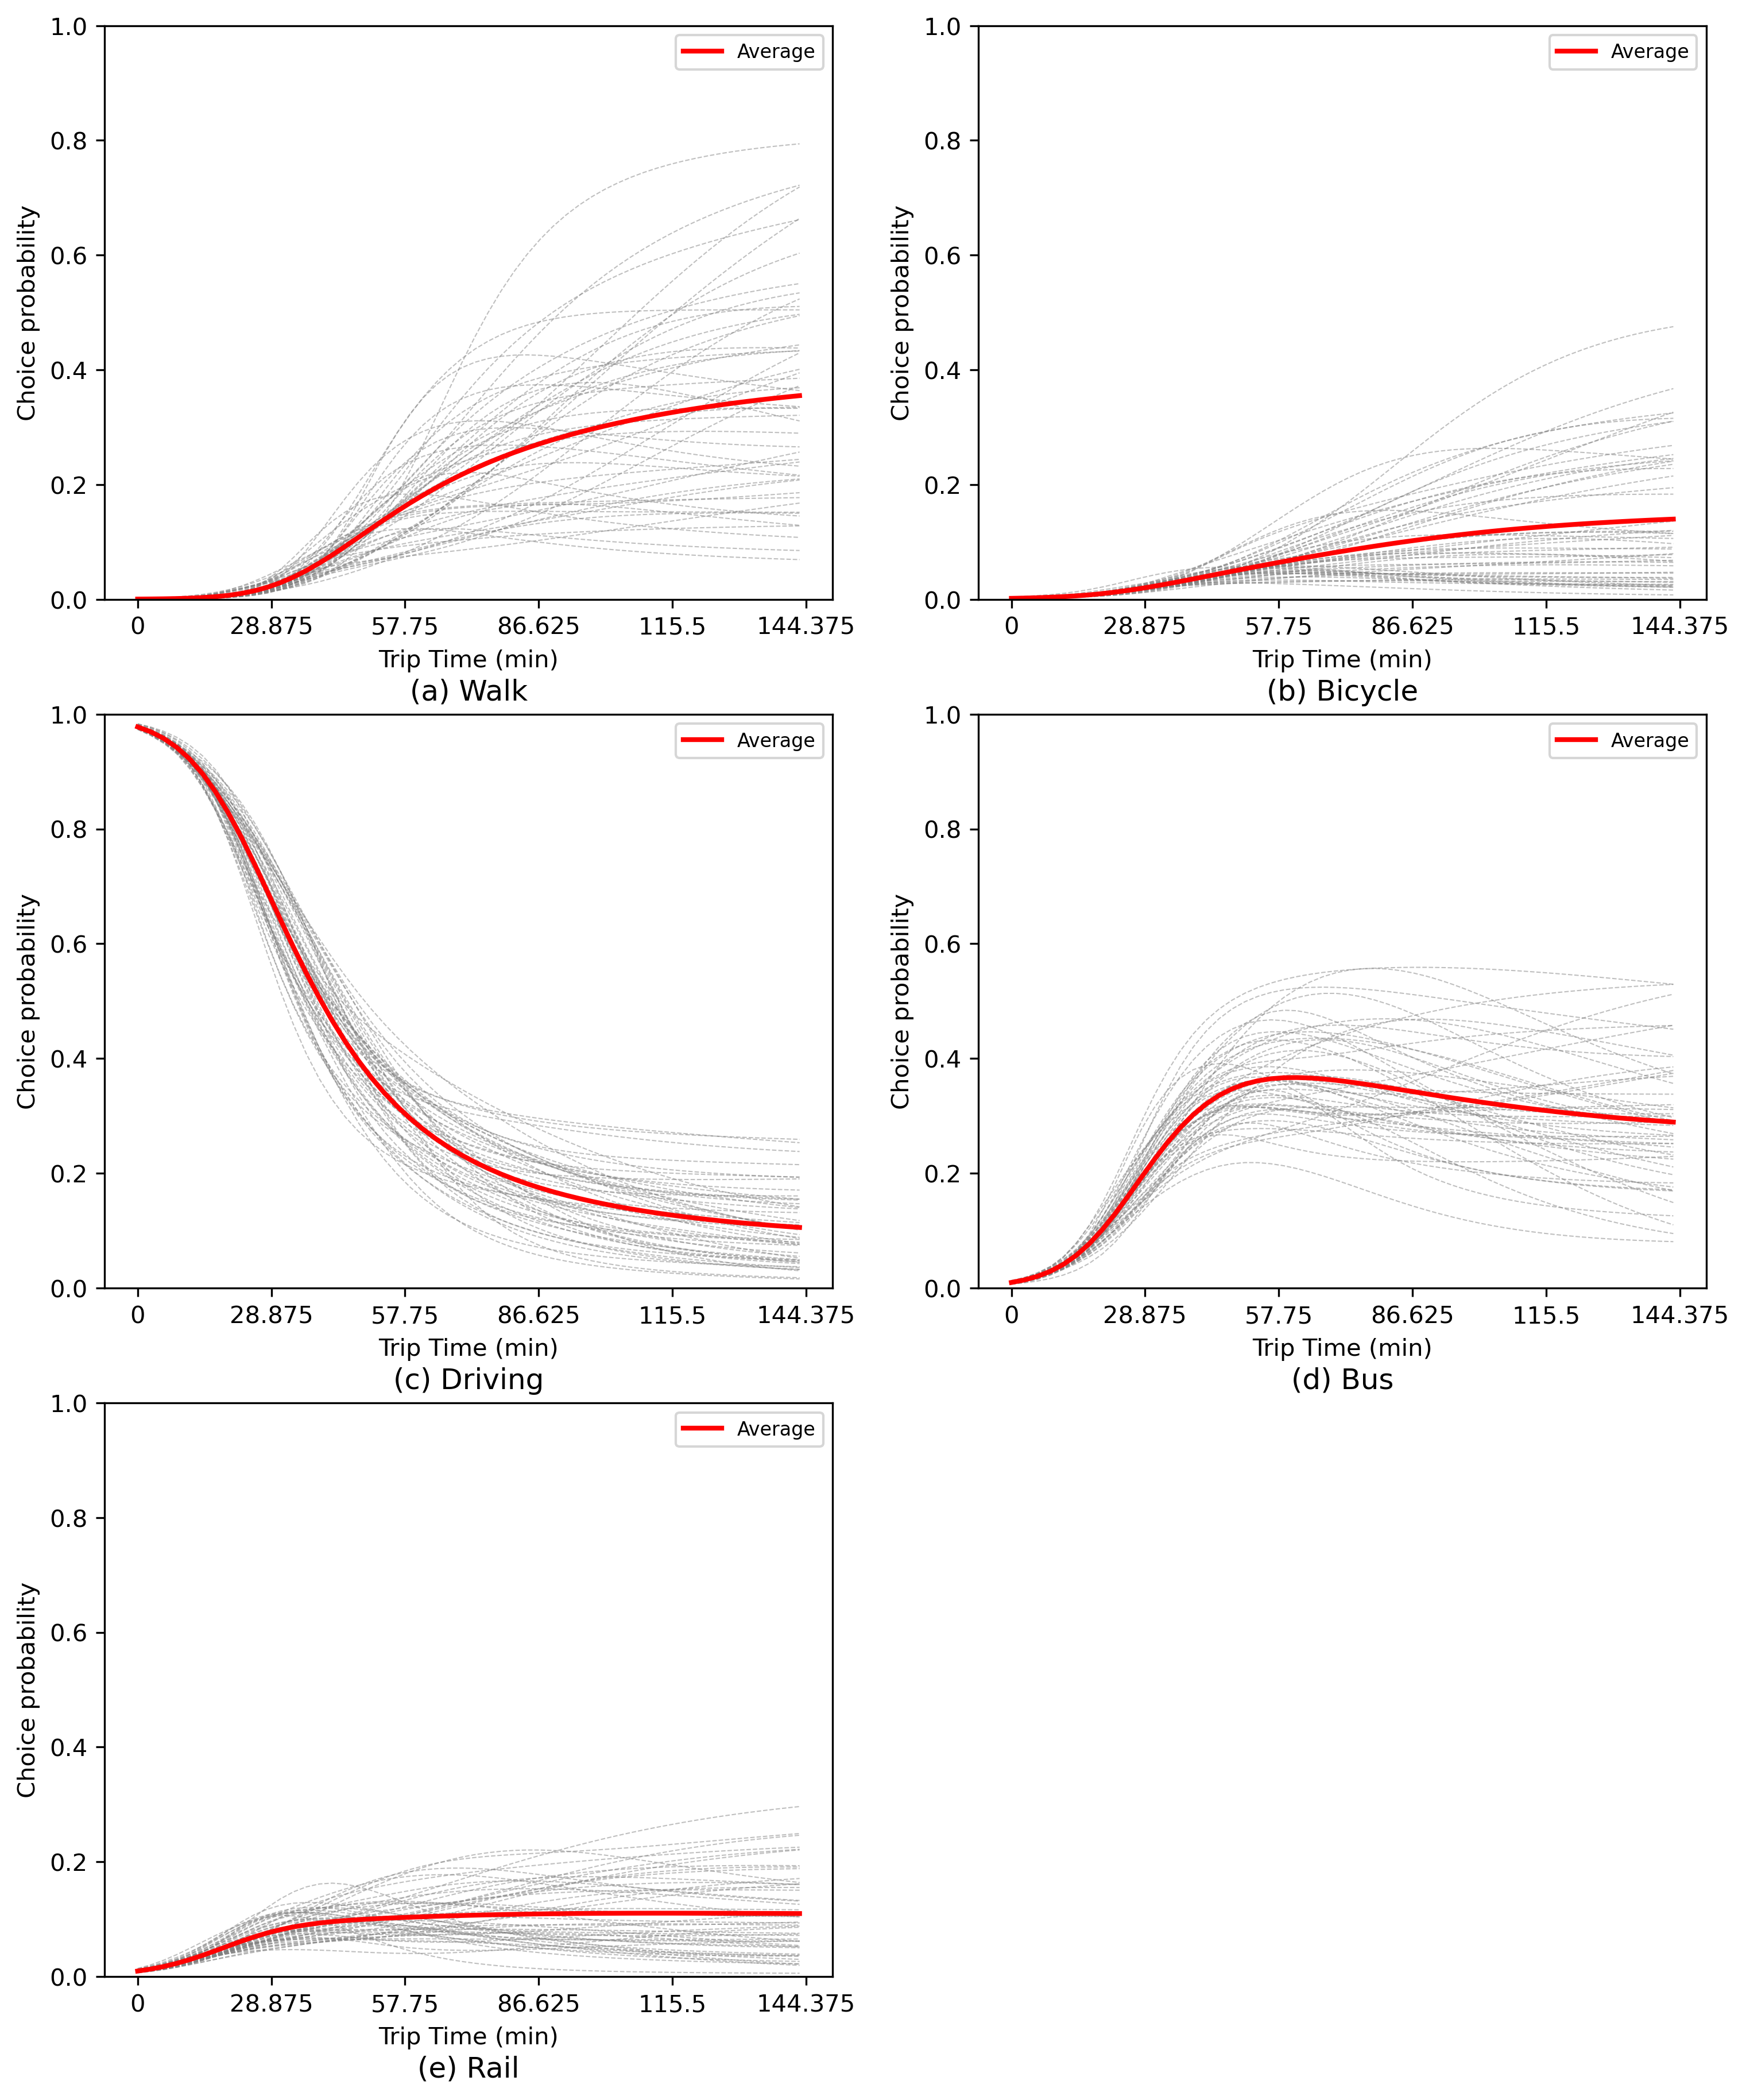

In [81]:
#Parameter
importlib.reload(util)
#the variable that we want to be the x-axis
fixed_effect = util.config['experiments']['variables']
var_name='Trip_time'
var=fixed_effect.index(var_name)

#set the xsticks
xticks1_max=data[fixed_effect[var]].max()/8
xticks2_max=data_non_stand[fixed_effect[var]].max()/8
xticks_num=[0,xticks1_max/5,xticks1_max*2/5,xticks1_max*3/5,xticks1_max*4/5,xticks1_max]
xticks=[0,xticks2_max/5,xticks2_max*2/5,xticks2_max*3/5,xticks2_max*4/5,xticks2_max]

#set the ymax and ymin
ymax=1
ymin=0

# x
x=np.arange(0,xticks1_max,0.1)

#if we use scipy.signal.savgol_filter() to smooth the curves
window_length=5
polyorder=1

year=years_str.index('2016')
# hold all other variables constant as their mean values
vars_mean=list(data_list[year][fixed_effect].mean())

y_ave=np.zeros((len(years_str),len(travel_mode),len(x)))

#color for regions and modes
color_mode= ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd']
color_region= plt.get_cmap('jet')(np.linspace(0.1, 0.9, len(region_name)))

#the year we want to plot
year=years_str.index('2016')

# set the color and label and the linestyles
seq=['a','b','c','d','e']
ave_color='red'
linestyle='--'

#plot
fig=plt.figure(dpi=300,figsize=(12,15)) 

y_region=np.zeros((50,len(region_name),len(x)))
y_ave=np.zeros((50,len(x)))

for mode in range(len(travel_mode)):
    fig.add_subplot(3,2,mode+1)
    plt.ylim(ymax=ymax,ymin=ymin)
    #plot regional average of each training result

    for _ in range(50):
        y_ave[_]=analysis.prob_function_bnn(x,years_str[year],result_para_dnn_50[_],var,mode,vars_mean=vars_mean)
        plt.plot(x, y_ave[_],linestyle=linestyle,linewidth=0.5,alpha=0.5,c='grey')
        
    y=np.mean(y_ave,axis=0)
    plt.plot(x,y,linewidth=2,label='Average',c=ave_color)

    plt.xlabel('Trip Time (min)')
    plt.ylabel('Choice probability')
    plt.xticks(xticks_num,xticks)
    plt.title(f'({seq[mode]}) {travel_mode[mode]}',y=-0.2)
    plt.legend(loc = 0, prop = {'size':8})

plt.savefig(f'./image/Probability functions of BNN learned by {years_str[year]} training set in different regions.png', dpi=300)


In [85]:
len(fixed_effect)

19

In [84]:
#Parameter
importlib.reload(util)
#the variable that we want to be the x-axis
fixed_effect = util.config['experiments']['variables']
var_name='Trip_time'
var=fixed_effect.index(var_name)


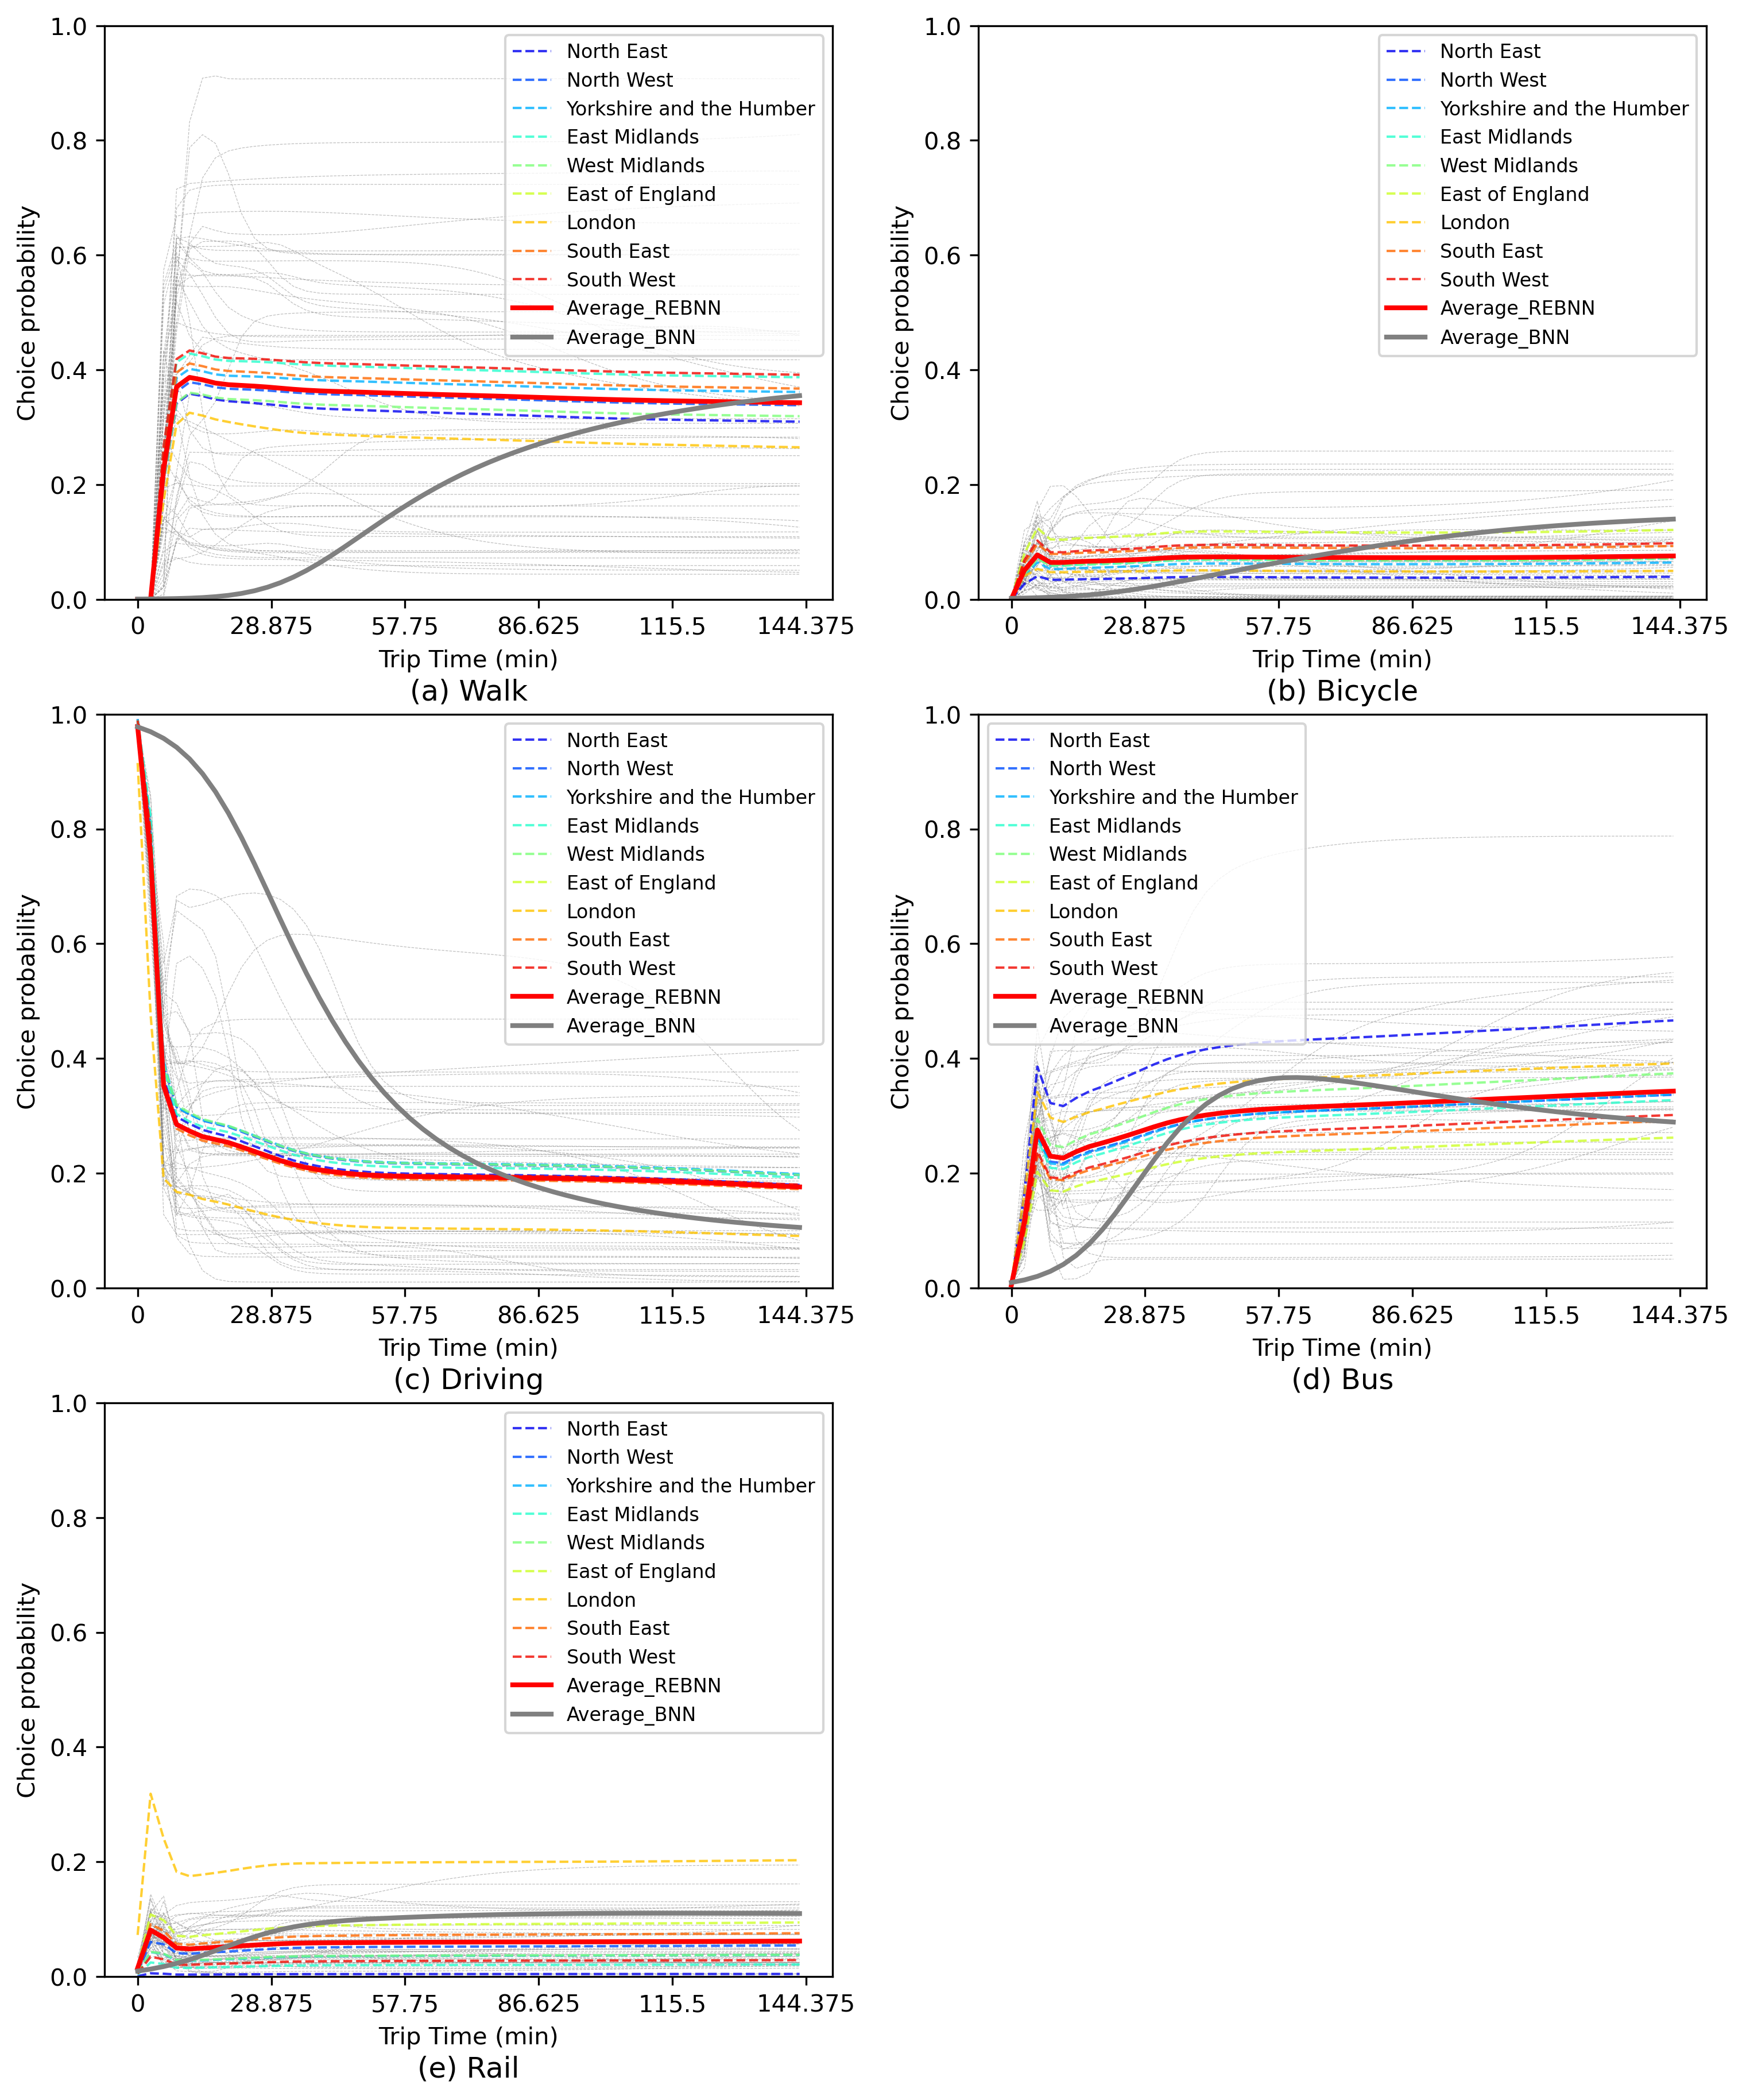

In [87]:

#set the xsticks
xticks1_max=data[fixed_effect[var]].max()/8
xticks2_max=data_non_stand[fixed_effect[var]].max()/8
xticks_num=[0,xticks1_max/5,xticks1_max*2/5,xticks1_max*3/5,xticks1_max*4/5,xticks1_max]
xticks=[0,xticks2_max/5,xticks2_max*2/5,xticks2_max*3/5,xticks2_max*4/5,xticks2_max]

#set the ymax and ymin
ymax=1
ymin=0

# x
x=np.arange(0,xticks1_max,0.1)

#if we use scipy.signal.savgol_filter() to smooth the curves
window_length=5
polyorder=1

#the variables in RE-BNN model
vars_rebnn=fixed_effect.copy()
vars_rebnn.remove('Population_density')

year=years_str.index('2016')
# hold all other variables constant as their mean values
vars_mean_rebnn=list(data_list[year][vars_rebnn].mean())
vars_mean=list(data_list[year][fixed_effect].mean())

y_ave=np.zeros((len(years_str),len(travel_mode),len(x)))

#color for regions and modes
color_mode= ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd']

#the year we want to plot
year=years_str.index('2016')
 
# set the color and label and the linestyles
seq=['a','b','c','d','e']
ave_color='red'
linestyle='--'

#plot
fig=plt.figure(dpi=300,figsize=(12,15)) 

y_region=np.zeros((50,len(region_name),len(x)))
y_ave=np.zeros((50,len(x)))
y_ave_bnn=np.zeros((50,len(x)))

for mode in range(len(travel_mode)):
    fig.add_subplot(3,2,mode+1)
    plt.ylim(ymax=ymax,ymin=ymin)
    #plot regional average of each training result
    for _ in range(50):
        for j in range(len(region_name)):
            y=analysis.prob_function_rebnn(x,years_str[year],result_para_rebnn_50[_],var,mode,region=j,vars_mean=vars_mean_rebnn)
#             plt.plot(x,y,linestyle=linestyle,linewidth=0.5,alpha=0.1,c='grey')
            y_region[_][j]=y
        y_ave[_]=np.mean(y_region[_],axis=0)
        plt.plot(x,y_ave[_],linestyle=linestyle,linewidth=0.3,alpha=0.5,c='grey')
        
    #plot rverage curves of training results in different regions
    for j in range(len(region_name)): 
        y=np.mean(y_region,axis=0)[j]
        plt.plot(x,y,linestyle=linestyle,linewidth=1,alpha=0.8,label=region_name[j],c=color_region[j])
    y=np.mean(y_ave,axis=0)
    plt.plot(x,y,linewidth=2,label='Average_REBNN',c='red')

    for _ in range(50):
        y_ave_bnn[_]=analysis.prob_function_bnn(x,years_str[year],result_para_dnn_50[_],var,mode,vars_mean=vars_mean)
        # plt.plot(x, y_ave[_],linestyle=linestyle,linewidth=0.5,alpha=0.5,c='grey')
        
    y=np.mean(y_ave_bnn,axis=0)
    plt.plot(x,y,linewidth=2,label='Average_BNN',c='grey')

    plt.xlabel('Trip Time (min)')
    plt.ylabel('Choice probability')
    plt.xticks(xticks_num,xticks)
    plt.title(f'({seq[mode]}) {travel_mode[mode]}',y=-0.2)
    plt.legend(loc = 0, prop = {'size':8})

plt.savefig(f'./image/Probability functions of RE-BNN and BNN learned by {years_str[year]} training set in different regions.png', dpi=300)

## Travel Mode Share

Now we choose the training results trained by 2016 dataset to test the travel mode share in different region.

In [67]:
# read the dataset(use to extract the region information of each observation)
data2016=analysis.dataset_year(2016)

In [68]:
year='2016'
#the ture market shares in 2016 testing set
mks_true=analysis.mks_region(data2016, prob_rebnn_true_50[0][year],df=True)
mks_true.to_csv(f'./results/mks_true in {year}.csv')
mks_true

Mode  North East  North West  Yorkshire and the Humber  East Midlands  \
0     Walk    0.100729    0.100882                  0.106456       0.108461   
1  Bicycle    0.016567    0.014703                  0.018001       0.017641   
2  Driving    0.799867    0.808867                  0.813160       0.812480   
3      Bus    0.082174    0.056322                  0.048417       0.048677   
4     Rail    0.000663    0.019226                  0.013966       0.012741   

   West Midlands  East of England    London  South East  South West  
0       0.079895         0.090780  0.123006    0.089585    0.123526  
1       0.013462         0.029710  0.023441    0.016410    0.026390  
2       0.846649         0.807121  0.520783    0.830543    0.802920  
3       0.047703         0.027588  0.137023    0.025117    0.036777  
4       0.012291         0.044801  0.195747    0.038346    0.010387

In [51]:
mks_rebnn=np.zeros((50,len(travel_mode),len(region_name)))
mks_bnn=np.zeros((50,len(travel_mode),len(region_name)))
mks_dnn=np.zeros((50,len(travel_mode),len(region_name)))
for _ in range(50):
    mks_rebnn[_]=analysis.mks_region(data2016, prob_rebnn_pre_50[_][year])
    mks_bnn[_]=analysis.mks_region(data2016, prob_bnn_pre_50[_][year])
    mks_dnn[_]=analysis.mks_region(data2016, prob_dnn_pre_50[_][year])
mks_mnl=analysis.mks_region(data2016, prob_mnl_pre[year])

In [54]:
pd.DataFrame(np.mean(mks_rebnn,axis=0)).to_csv(f'results\\mks_rebnn(ave) in {year}.csv')
pd.DataFrame(np.mean(mks_bnn,axis=0)).to_csv(f'results\\mks_bnn(ave) in {year}.csv')
pd.DataFrame(np.mean(mks_dnn,axis=0)).to_csv(f'results\\mks_dnn(ave) in {year}.csv')

pd.DataFrame(np.std(mks_rebnn,axis=0)).to_csv(f'results\\mks_rebnn(std) in {year}.csv')
pd.DataFrame(np.std(mks_bnn,axis=0)).to_csv(f'results\\mks_bnn(std) in {year}.csv')
pd.DataFrame(np.std(mks_dnn,axis=0)).to_csv(f'results\\mks_dnn(std) in {year}.csv')

pd.DataFrame(mks_mnl).to_csv(f'results\\mks_mnl in {year}.csv')